# Прогнозирование оттока клиентов в сети отелей 

**Описание проекта:**

Сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако, если клиент отменяет бронирование, то компания терпела убытки.

**Цель проекта:** 

Разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Дополнительная информация:**

Размер депозита - 80% от стоимости номера за одни сутки и завтрат на разовую уборку. 

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также завтра на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
- категория A: ночь - 1 000, разовое обслуживание - 400;
- категория B: ночь - 800, разовое обслуживание - 350;
- категория C: ночь - 600, разовое обслуживание - 350;
- категория D: ночь - 550, разовое обслуживание - 150;
- категория E: ночь - 500, разовое обслуживание - 150;
- категория F: ночь - 450, разовое обслуживание - 150;
- категория G: ночь - 350, разовое обслуживание - 150.

В ценовой политике отеля используется сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом - на 40%. 

Убытки отеля в случае отмены брони номера - стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет - 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

**Описание данных:**
- `id` - номер записи;
- `adults` - количество взрослых постояльцев;
- `arrival_date_year` - год заезда;
- `arrival_date_month` - месяц заезда;
- `arrival_date_week_number` - неделя заезда;
- `arrival_date_day_of_month` - день заезда;
- `babies` - количество младенцев;
- `booking_changes` - количество изменений параметров заказа;
- `children` - количество  детей в возрасте от 3 до 14 лет;
- `country` - гражданство постояльца;
- `customer_type` - тип заказчика:
    - `Contract` - договор с юридическим лицов;
    - `Group` - групповой заезд;
    - `Transient` - не связано с договором или групповым заездом;
    - `Transiet-party` - не связано с договором или групповым заездом, но связано с бронирование типа `Transiet`.
- `days_in_waiting_list` - сколько дней заказ ожидал подтверждения;
- `distribution_channel` - канал дистибуции заказа;
- `is_canceled` - отмена заказа;
- `is_repeated_guest` - признак того, что гость бронирует номер второй раз;
- `lead_time` - количество дней между датой бронирования и датой прибытия;
- `mean` - опции заказа:
    - `SC` - нет дополнительных опций;
    - `BB` - включён завтрак;
    - `HB` - включён завтрак и обед;
    - `FB` - включён завтрак, обед и ужин.
- `previous_booking_not_canceled` - количество подтверждённых заказов у клиента;
- `previoues_cancellations` - количество отменённых заказов у клиента;
- `required_car_parking_spaces` - необходимость места для автомобиля;
- `reserved_room_type` - тип забронированной комнаты;
- `stays_in_weekend_nights` - количество ночей в выходные дни;
- `stays_in_week_nights` - количество ночей в будние дни;
- `total_nights` - общее количество ночей;
- `total_of_special_requests` - количество специальных отметок.

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import category_encoders as ce

#Зададим RandomState, чтобы в последстии ответы можно было воспроизвести повторно
state = np.random.RandomState(1337)

Отключим предупреждения.

In [2]:
import warnings
warnings.filterwarnings("ignore")

Снимем ограничение на количество отображаемых столбцов DataFrame.

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data_train = pd.read_csv('hotel_train.csv')
data_test = pd.read_csv('hotel_test.csv')

In [5]:
print(data_train.info())
print('Количество дубликатов:', data_train.duplicated().sum())
display(data_train.describe())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [6]:
print(data_test.info())
print('Количество дубликатов:', data_test.duplicated().sum())
display(data_test.describe())
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


Предварительно данные в порядке: дубликатов и пропущенных значений нет. Но надо поработать над типами данных, например, не везде необходим `float64` иногда дотсаточно `int64`.

### Шаг 2. Предобработка и исследовательский анализ данных

Начнём с типов данных. Необходимо в столбцах `lead_time`, `adults`, `children`, `babies` изменить тип данных с `float64` на `int64`.

In [7]:
data_train[['lead_time', 'adults', 'children', 'babies']] = data_train[['lead_time', 'adults', 'children', 'babies']].astype('int')
data_test[['lead_time', 'adults', 'children', 'babies']] = data_test[['lead_time', 'adults', 'children', 'babies']].astype('int')

Удалим столбцы `id` в каждом датафрейме, поскольку он нам не нужен.

In [8]:
data_train.drop(['id'],axis=1, inplace=True)
data_test.drop(columns='id', inplace=True)

Теперь проверим на дубликаты полученные датафреймы.

In [9]:
print('Дубликатов в data_train:', data_train.duplicated().sum(), '|', f'{round(data_train.duplicated().sum() / data_train.shape[0] * 100, 2)}%')
print('Дубликатов в data_test:', data_test.duplicated().sum(), '|', f'{round(data_test.duplicated().sum() / data_test.shape[0] * 100, 2)}%')

Дубликатов в data_train: 21377 | 32.77%
Дубликатов в data_test: 7717 | 23.81%


Ужасающий результат. Судя по признакам, это не может быть просто совпадением. Но это вполне могли быть несколько бронирований, сделанных одним клиентом в один день. Проверить наверняка мы это не можем. Поэтому удалять не будем.

Проверим категориальные столбцы на скрытые дубликаты.

In [10]:
for data in [data_train, data_test]:
    for col in data_train.loc[:, data.dtypes == 'object'].columns:
        print(sorted(data[col].unique()))
        print(f'Количество уникальных значений {col}:', data[col].nunique(), '\n')

['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']
Количество уникальных значений arrival_date_month: 12 

['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       ']
Количество уникальных значений meal: 5 

['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MWI', 'MYS', 

**Наблюдения по столбцам `data_train`:**
- в `arrival_date_month`, `country`, `distribution_channel`, `customer_type` всё в порядке;
- в `meal` уникальных значений 5, хотя по условию должно быть 4, в параметрах присутствуют пробелы;
- в `reserved_room_type` в параметрах присутствуют пробелы.

**Наблюдения по столбцам `data_test`:**
- в `arrival_date_month`, `country`, `distribution_channel`, `customer_type` всё в порядке;
- в `meal` такая же проблема, как и в столбце `meal` из `data_train`;
- в `reserved_room_type` в параметрах присутствуют пробелы.

Исправим.

In [11]:
for data in [data_train, data_test]:
    for col in ['meal', 'reserved_room_type']:
        data[col] = data[col].str.strip()
        print(sorted(data[col].unique()))
        print(f'Количество уникальных значений в {col}:', data[col].nunique())


['BB', 'FB', 'HB', 'SC']
Количество уникальных значений в meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений в reserved_room_type: 7
['BB', 'FB', 'HB', 'SC']
Количество уникальных значений в meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений в reserved_room_type: 7


Проверим, есть ли бронирования без взрослых и без детей. Если есть, то удалим такие строки, так как это вероятнее всего, аномалии.

In [12]:
print('Ноль постоялцев:', ((data_train[(data_train['adults'] == 0) & (data_train['children'] == 0)]['adults']) | (data_test[(data_test['adults'] == 0) & (data_test['children'] == 0)]['adults'])).count())

Ноль постоялцев: 22


In [13]:
for data in [data_train, data_test]:
    data.drop(data[(data['adults'] == 0) & (data['children'] == 0)]['adults'].index, inplace=True)

In [14]:
print('Ноль постоялцев:', ((data_train[(data_train['adults'] == 0) & (data_train['children'] == 0)]['adults']) | (data_test[(data_test['adults'] == 0) & (data_test['children'] == 0)]['adults'])).count())

Ноль постоялцев: 0


Успешно.

#### Исследовательский анализ

Начнём исследование с целевого признака `is_canceled`: проверим на выбросы, распределение и баланс.

In [15]:
colors = sns.color_palette('pastel')
sns.set(rc={'figure.figsize':(15,5)}, palette=colors) # Настройки таблиц

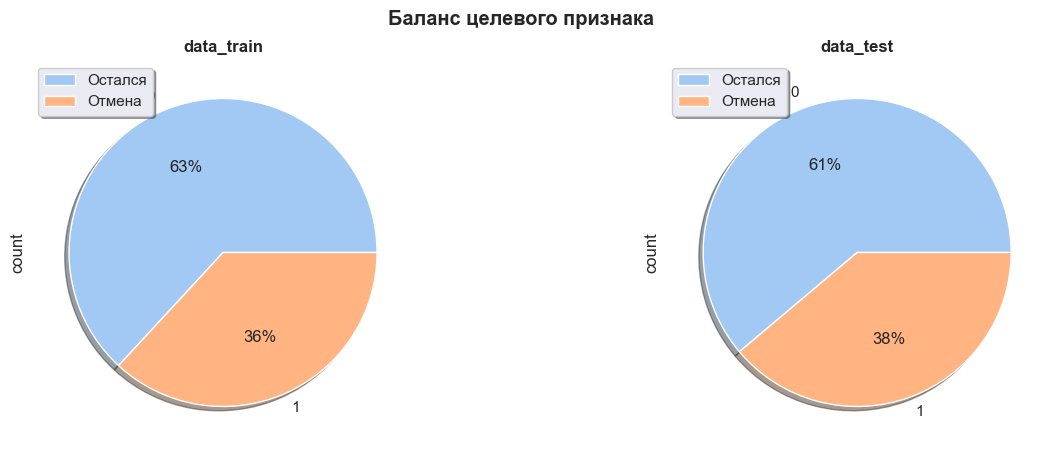

In [16]:
titles = ['data_train', 'data_test']
fig, ax = plt.subplots(1, 2)
fig.suptitle('Баланс целевого признака', fontweight='bold')
count = 0
for data in [data_train, data_test]:
    data.is_canceled.value_counts().plot(kind='pie', shadow=True, autopct='%1.1d%%', ax=ax[count])
    ax[count].legend(['Остался', 'Отмена'], shadow=True)
    ax[count].set_title(titles[count], fontweight='bold')
    count += 1
plt.show()

Наблюдаем дисбаланс целевого признака, который необходимо устранить.

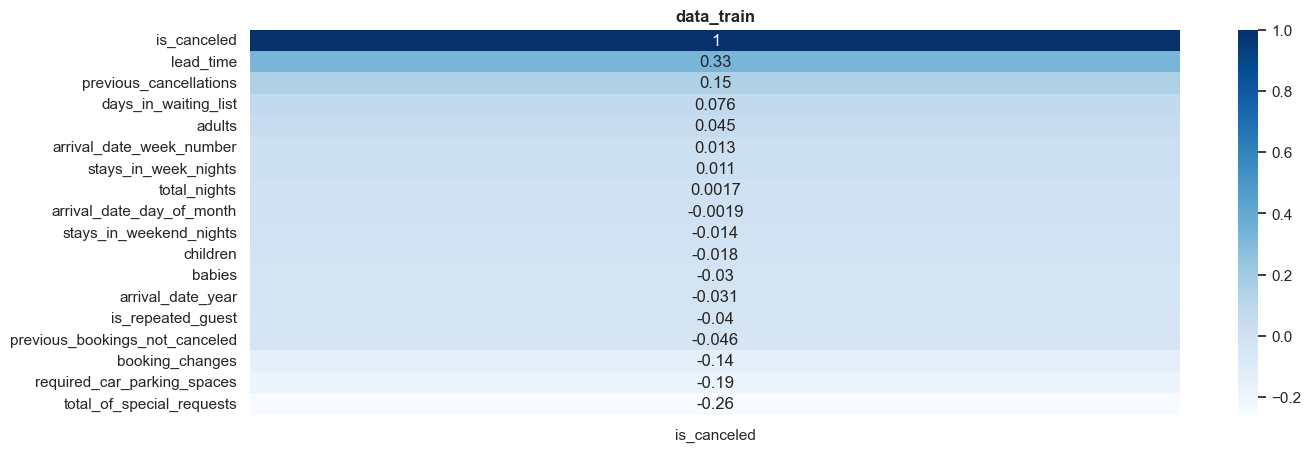

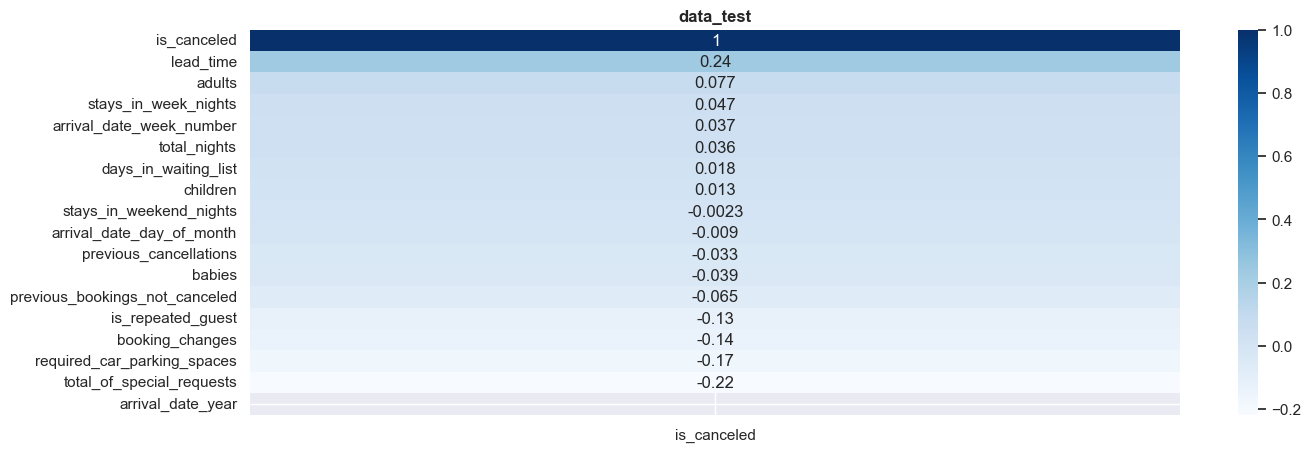

In [17]:
count = 0
for data in [data_train, data_test]:
    cols = ['arrival_date_month', 'meal', 'country', 'distribution_channel',  'reserved_room_type', 'customer_type']
    sns.heatmap(data.loc[:, ~data.columns.isin(cols)].corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
                annot=True, annot_kws={'size':12}, cmap='Blues')
    plt.title(titles[count], fontweight='bold')
    count += 1
    plt.show()

**Выводы:**
- Параметр `previous_cancellations` в тренировочной выборке имеет прямую зависимость с отменой бронирования, однако в тестовой выборке - обратную зависимость. Возможно, за 2017 год у нас имеются неполные данные по этой графе.

Проверим, равны ли совокупности столбца `previoues_cancellations` в двух датасетах. Выдвинем гипотезы:
- H0: равны;
- H1: не равны.

In [18]:
def hypothesis(data1, data2, sides):
    alpha = .05
    res = st.ttest_ind(data1, data2)
    print('p-value:', res.pvalue / sides)
    if (res.pvalue / sides) < alpha:
        print('Отвергаем нулеую гипотезу')
    else:
        print('Принимаем нулевую гипотезу')

In [19]:
hypothesis(data_train['previous_cancellations'], data_test['previous_cancellations'], 1)

p-value: 3.811849439806941e-104
Отвергаем нулеую гипотезу


Получается, обе совокупности не равны. Это может сказаться на качестве предсказаний, учитывая, что в тренировочной выборке данный столбец демонстрирует высокий уровень корреляции с целевым признаком.

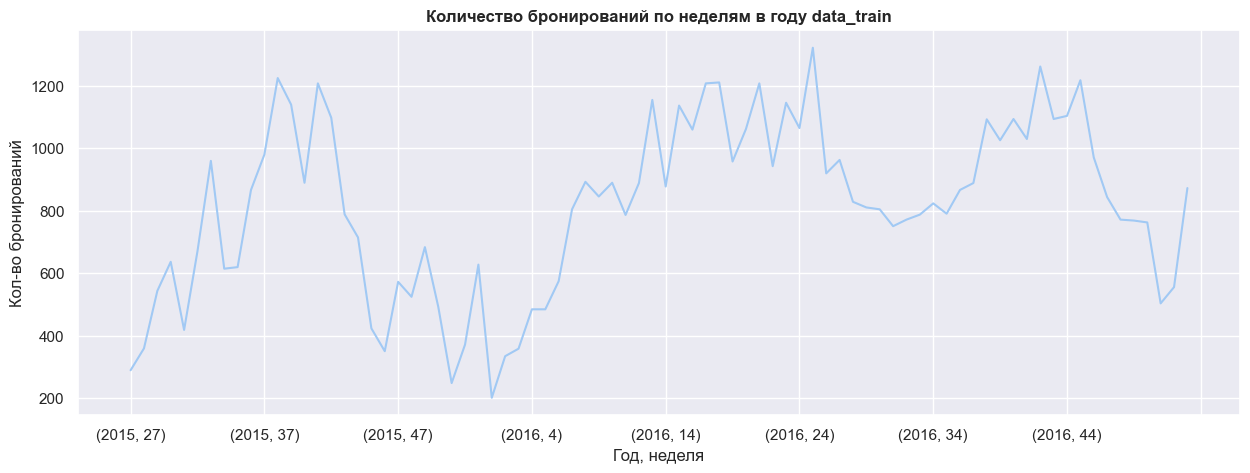

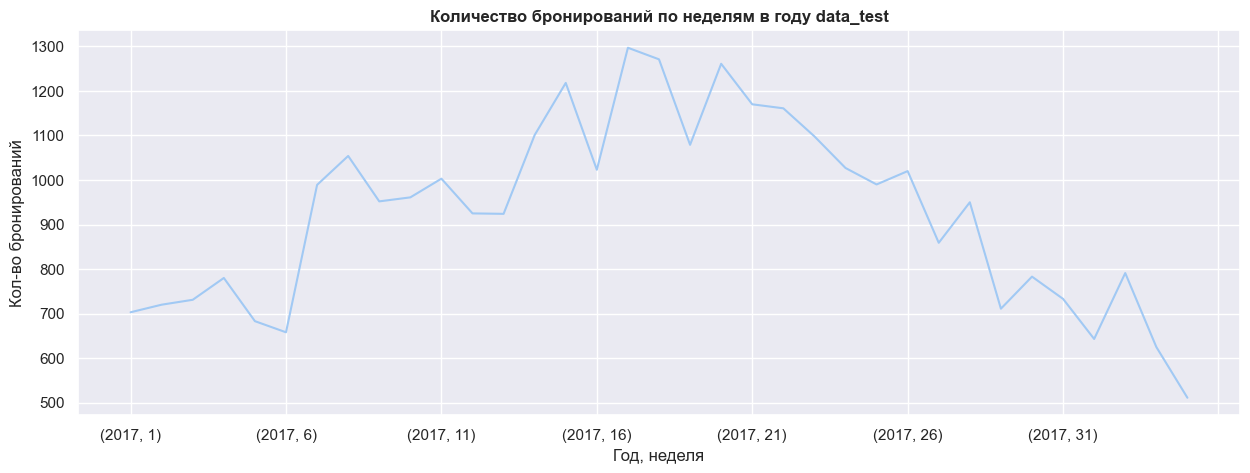

In [20]:
count = 0
for data in [data_train, data_test]:
    data.pivot_table(index=['arrival_date_year', 'arrival_date_week_number'],
                     values='is_canceled', aggfunc='count').plot(legend=None)
    plt.xlabel('Год, неделя')
    plt.ylabel('Кол-во бронирований')
    plt.title(f'Количество бронирований по неделям в году {titles[count]}', fontweight='bold')
    count += 1
    plt.show()

Как видим, пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности. Оживление может наблюдаться к Новому Году.

Рассмотрим распределения и ящики с усами всех параметром

In [21]:
def distribution_plots(data, name, title):
    fig, ax = plt.subplots(1, 2)
    fig.suptitle('Распределение ' + name, fontweight='bold', fontsize=20)
    
    sns.distplot(data, ax=ax[0])
    ax[0].set_ylabel('Плотность')
    ax[0].set_title(title, fontsize=18)

    sns.boxplot(data, ax=ax[1])
    ax[1].set_title(title, fontsize=18)
    plt.show()

In [22]:
def distribution(data, name):
    cols = [i for i in data_train.columns if (data_train[i].nunique() > 2) & (data_train[i].dtypes != 'object')]
    for col in cols:
        distribution_plots(data[col], name, col)

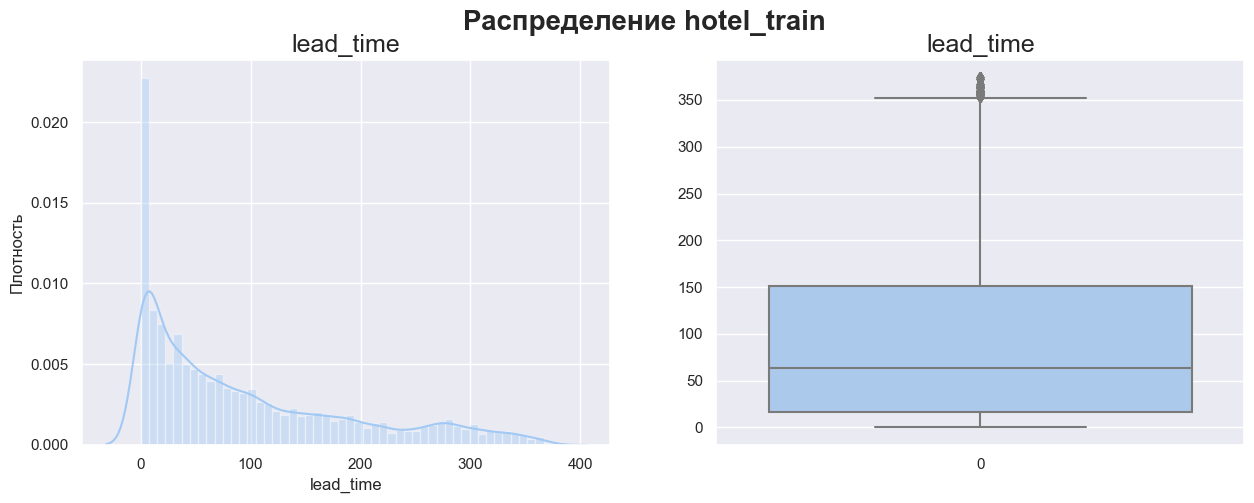

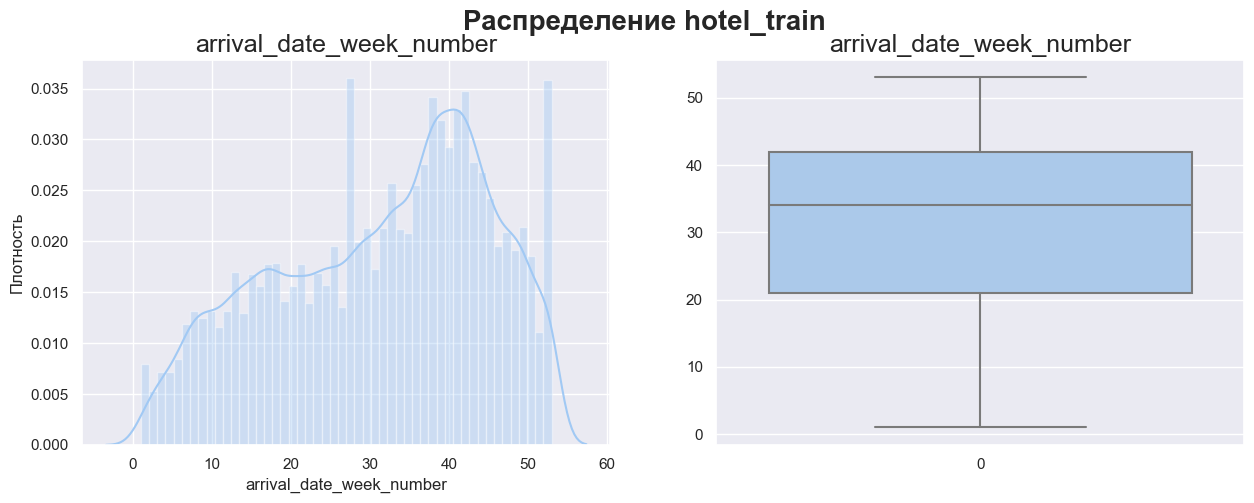

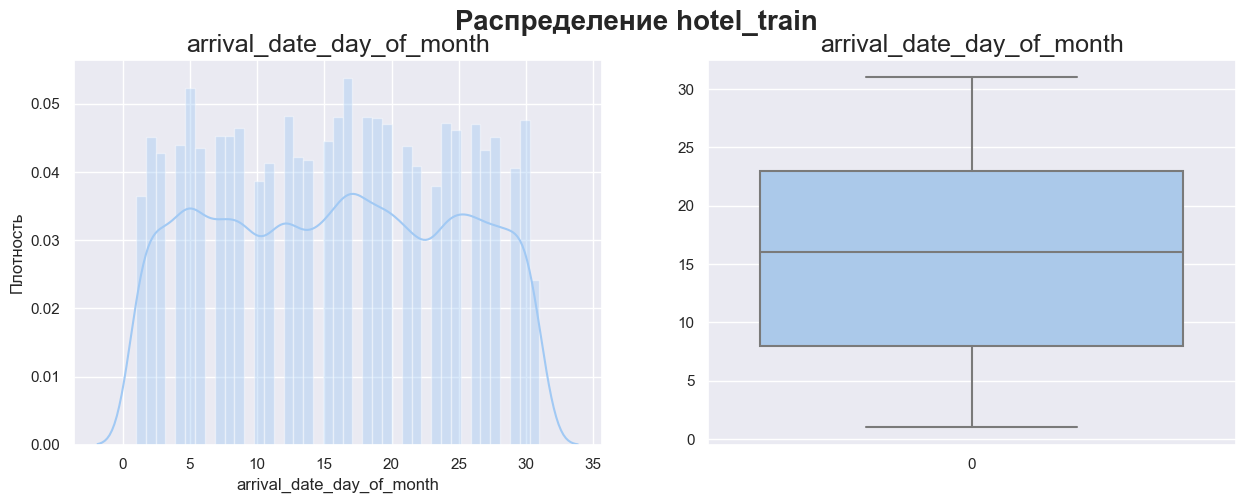

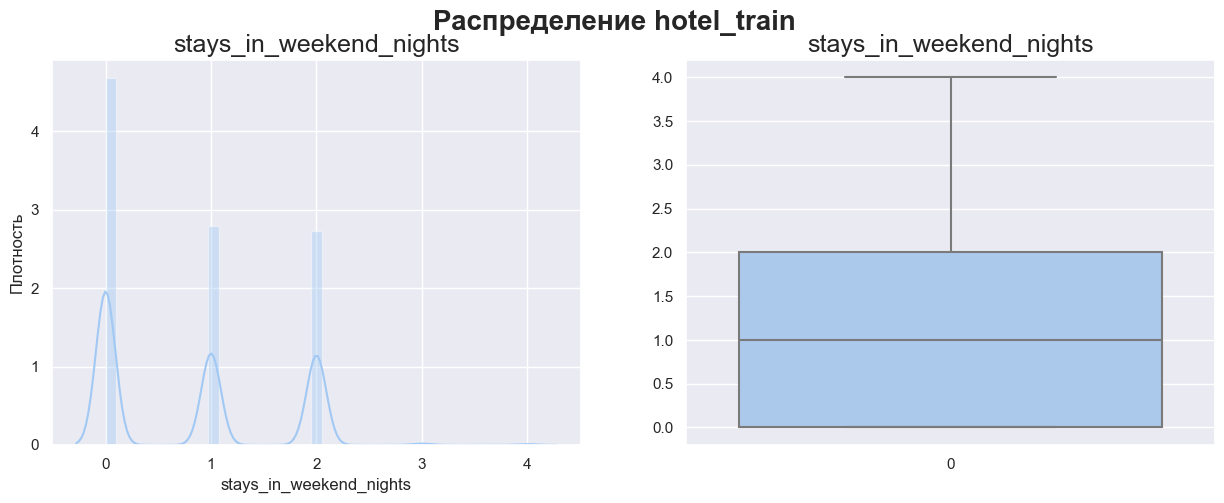

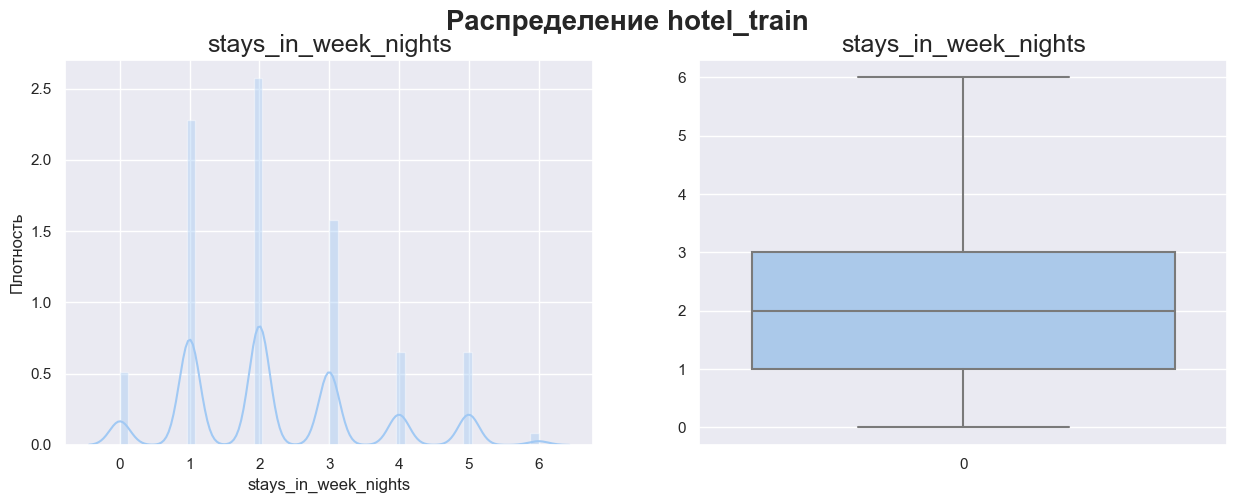

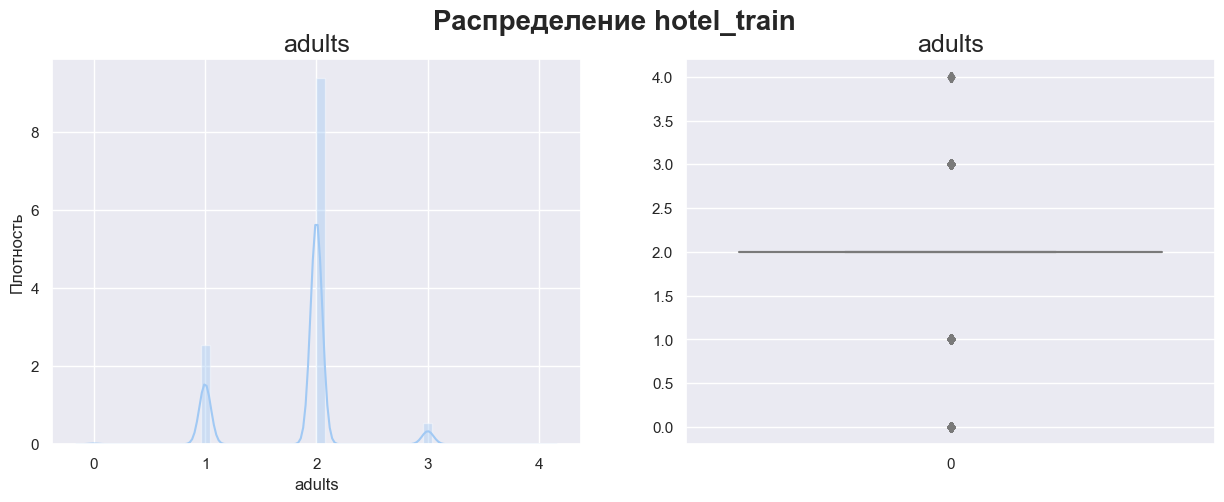

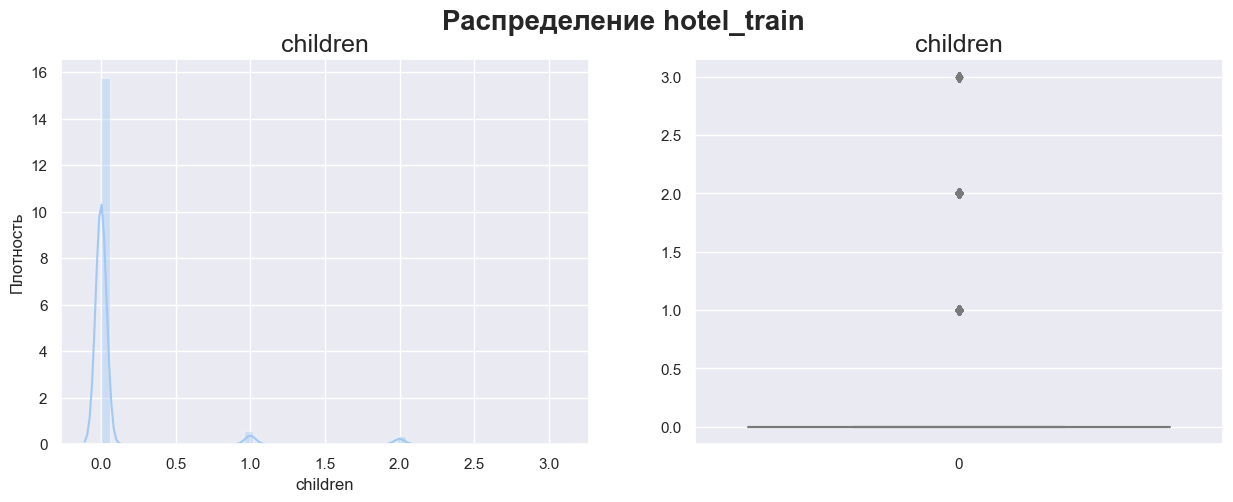

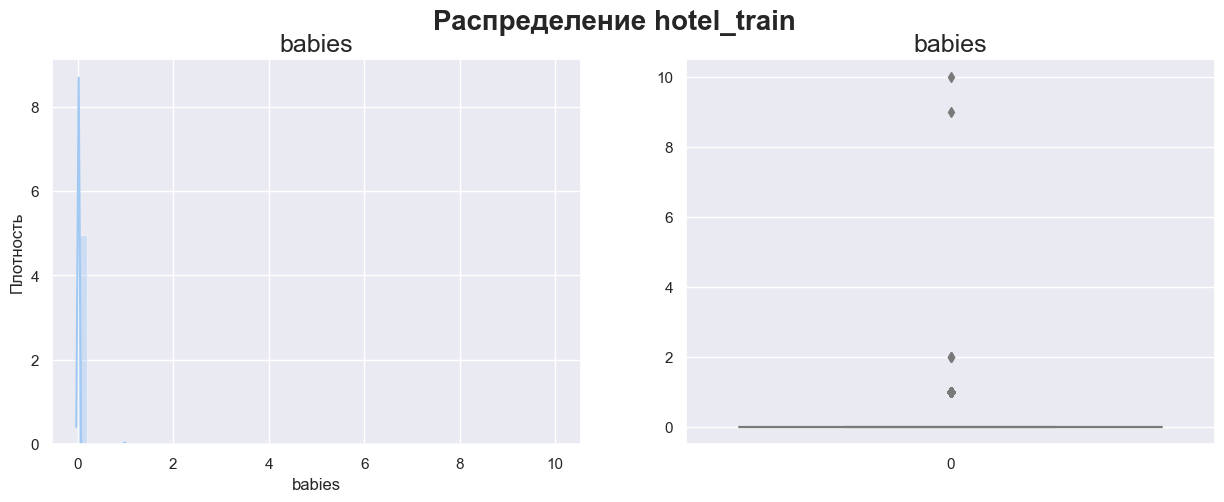

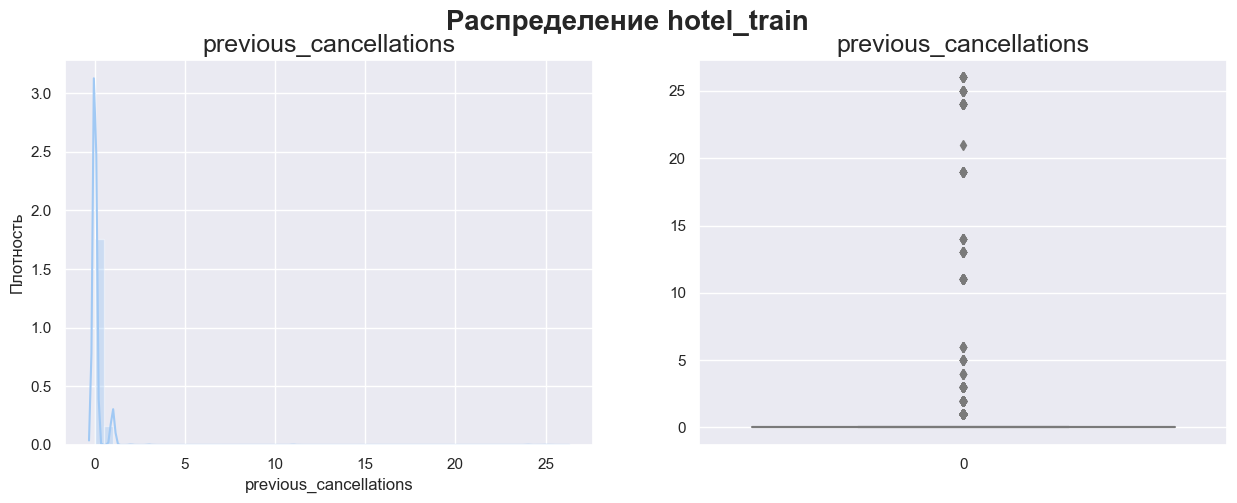

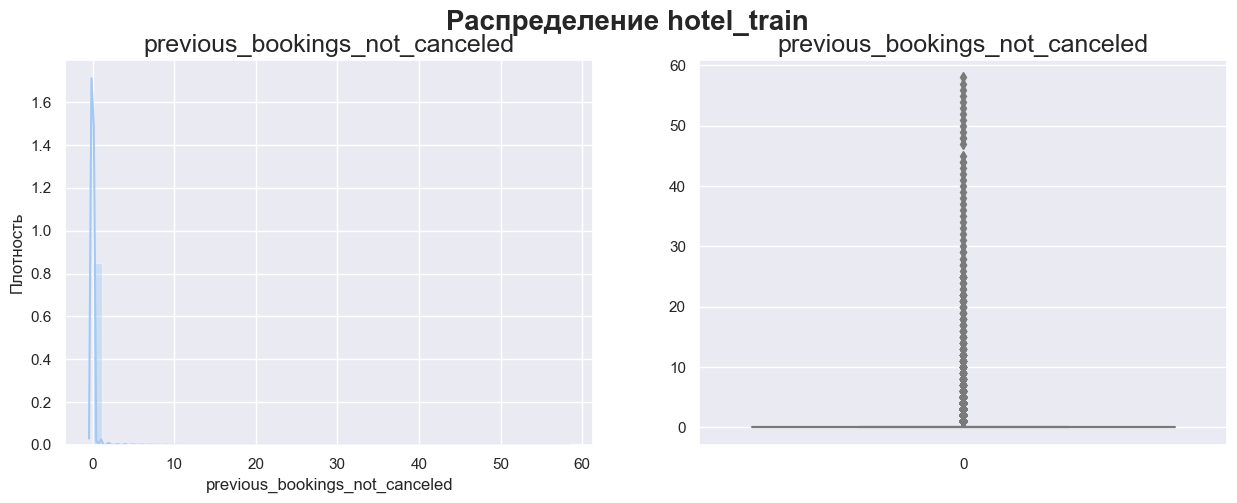

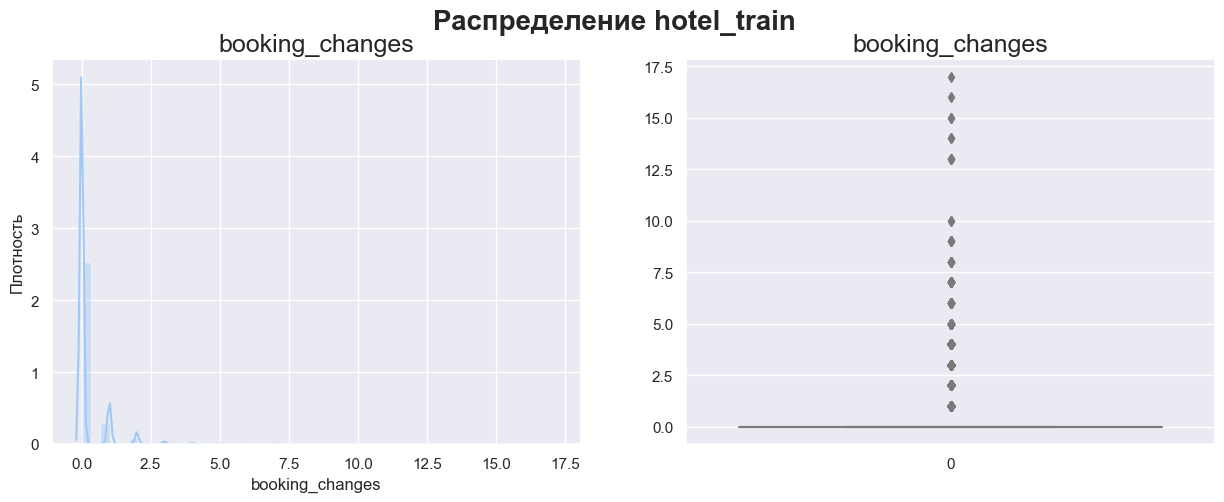

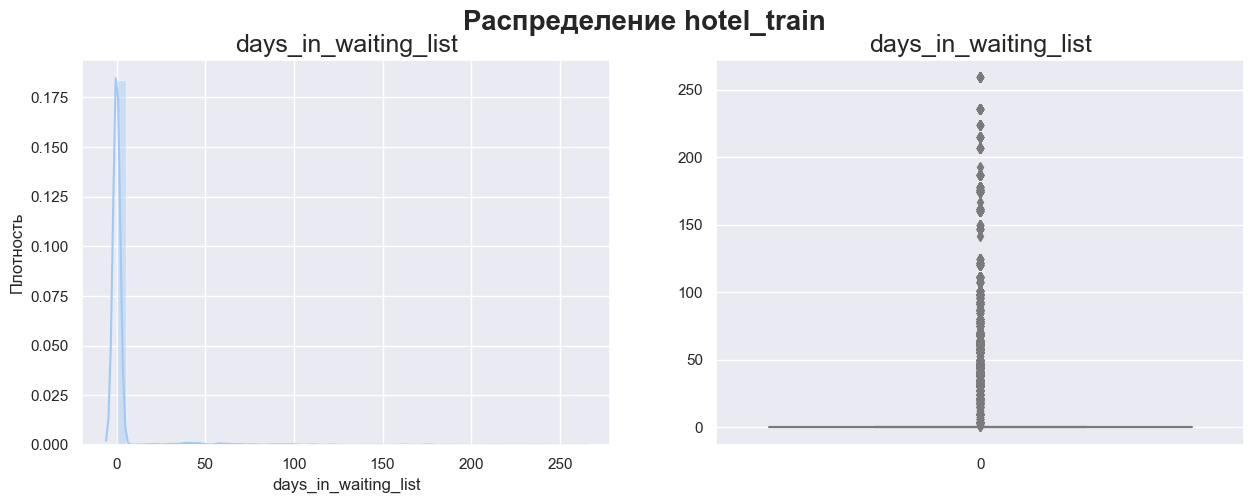

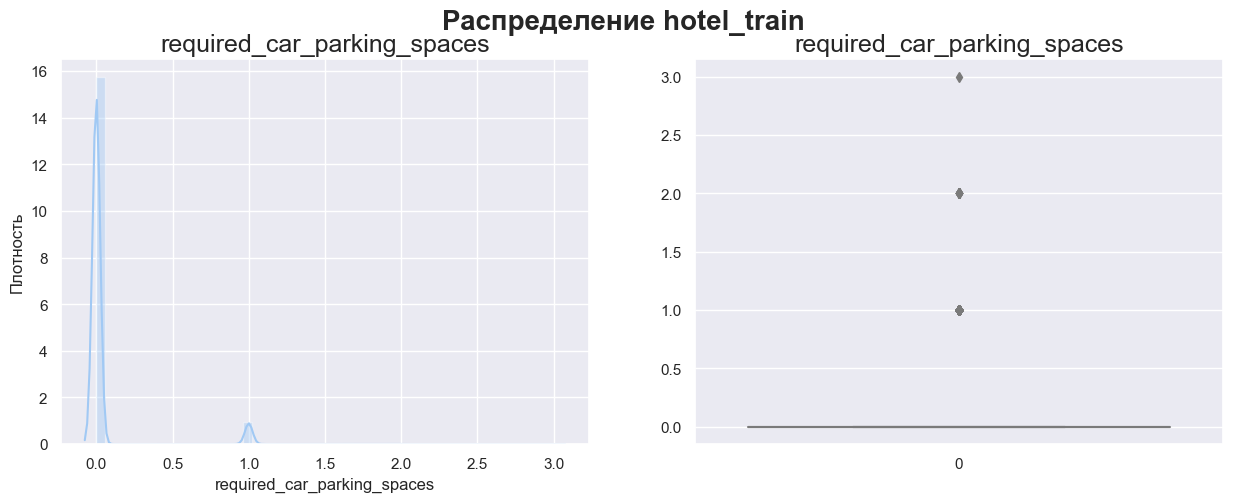

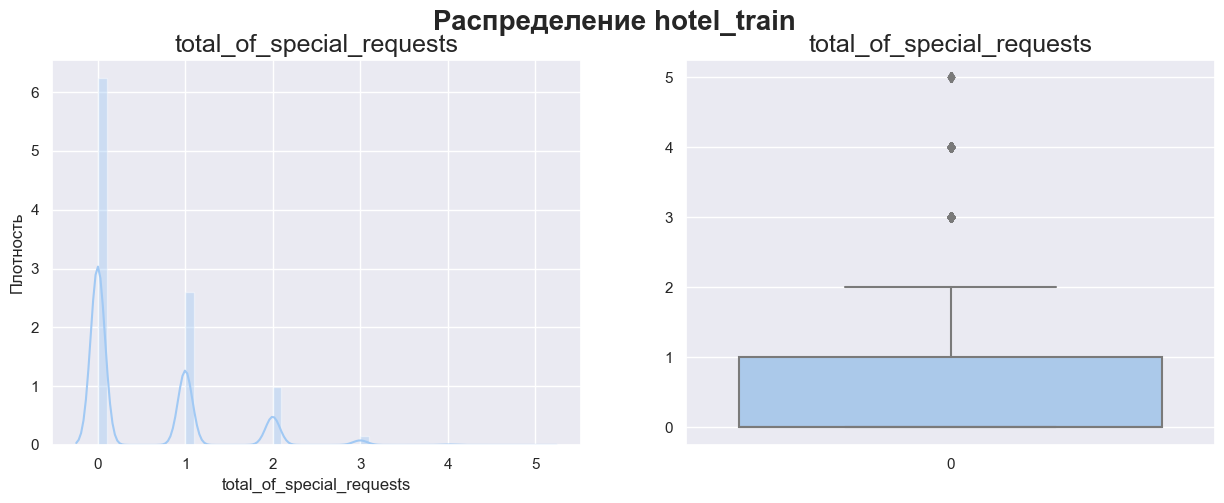

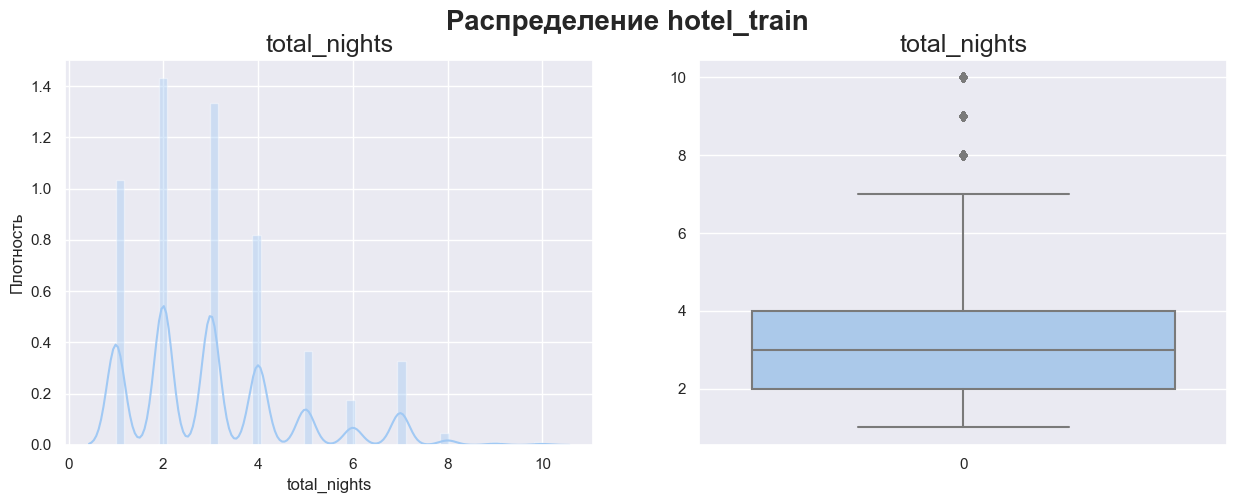

In [23]:
distribution(data_train, 'hotel_train')

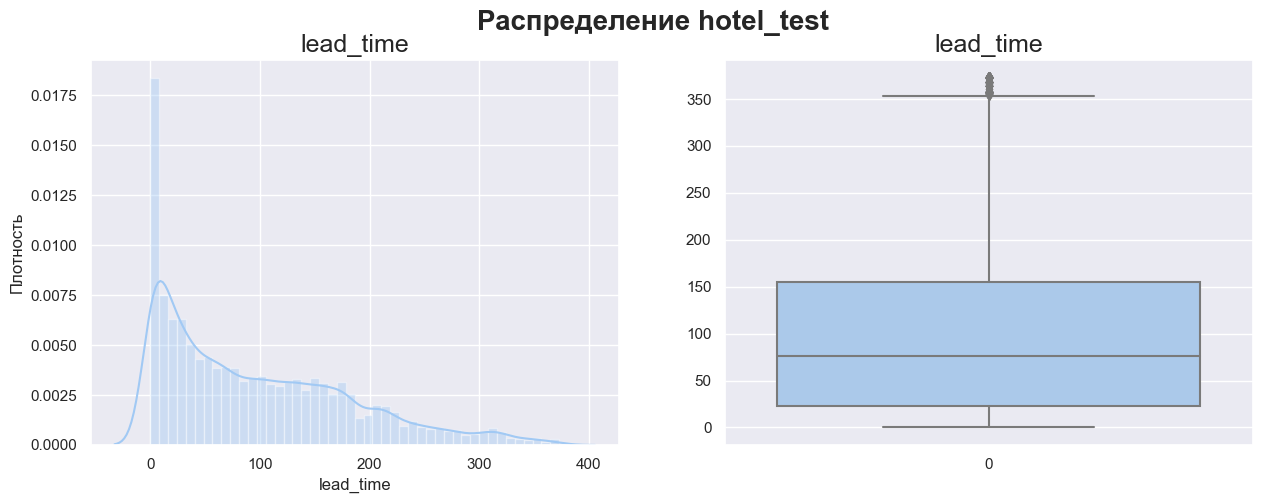

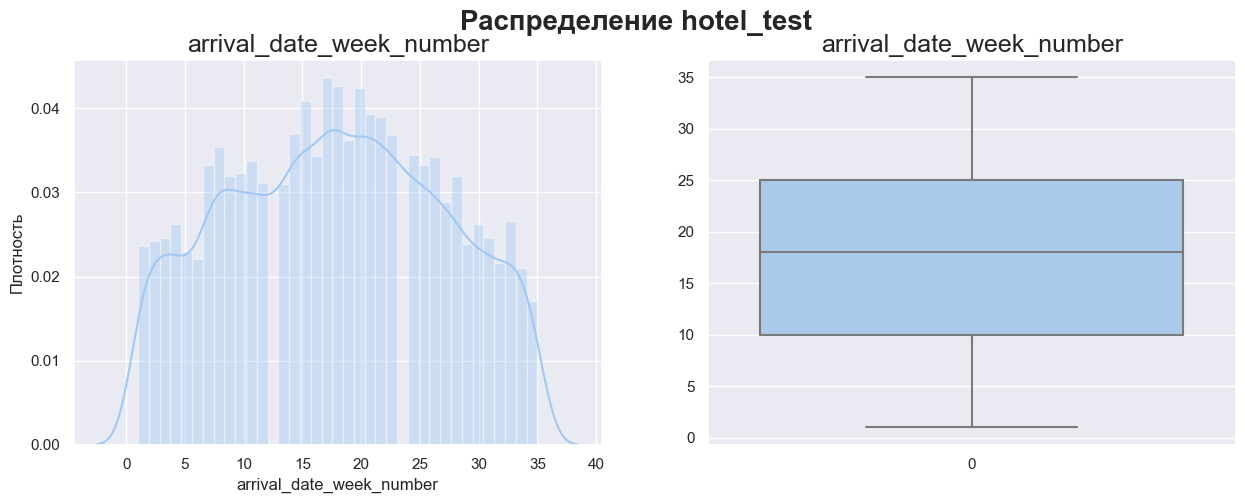

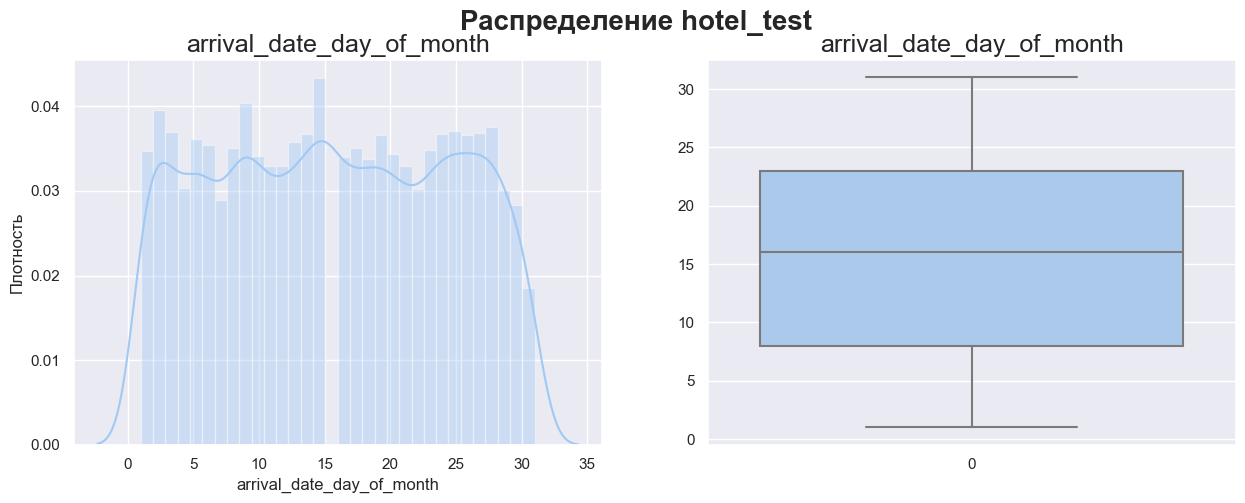

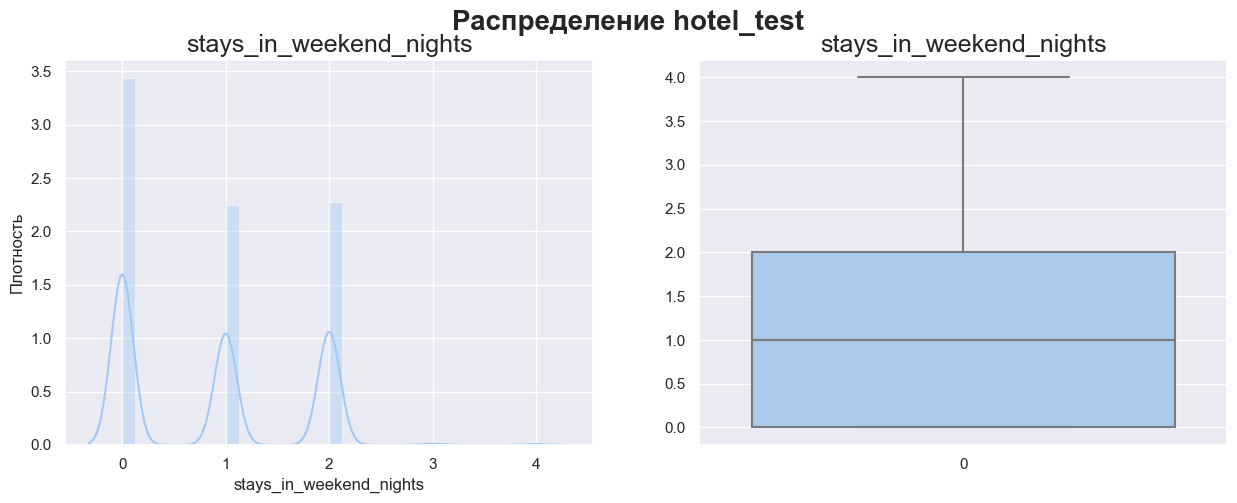

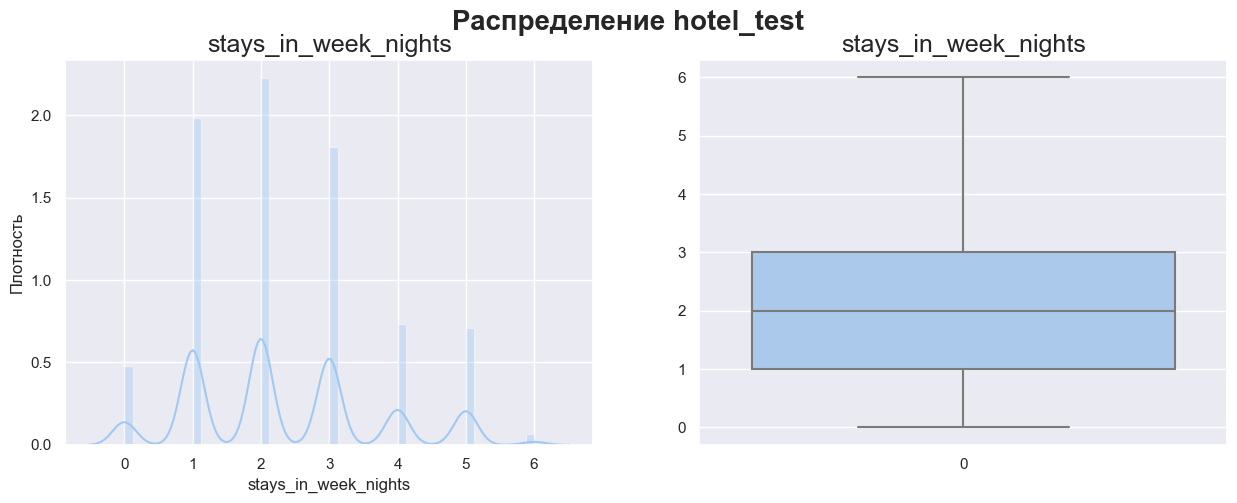

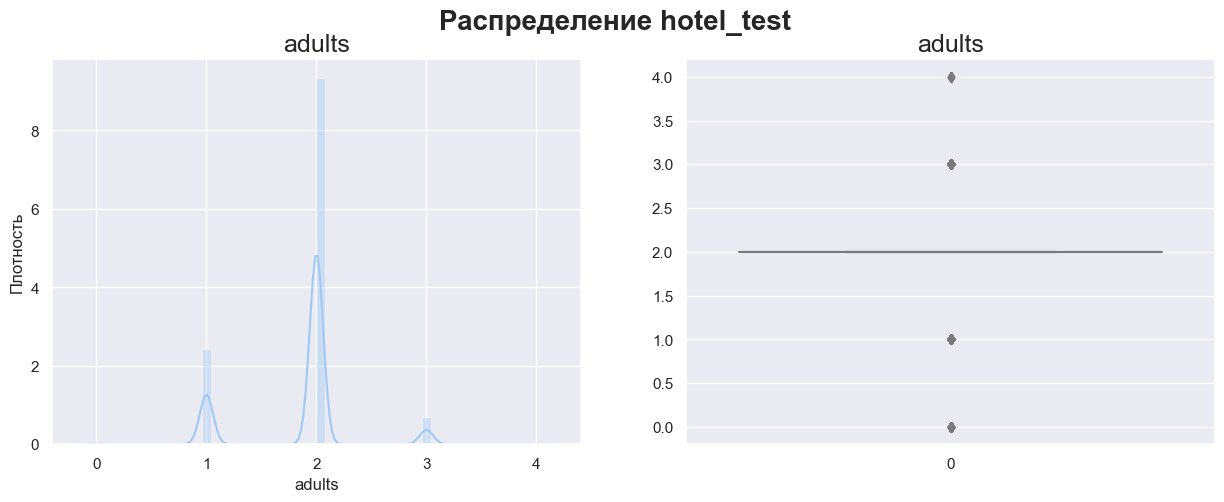

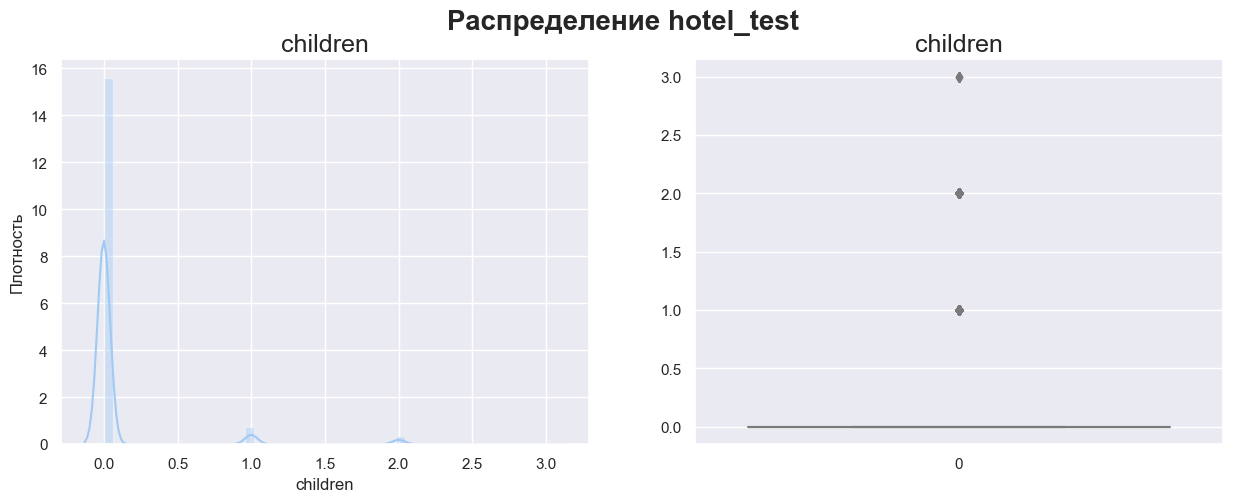

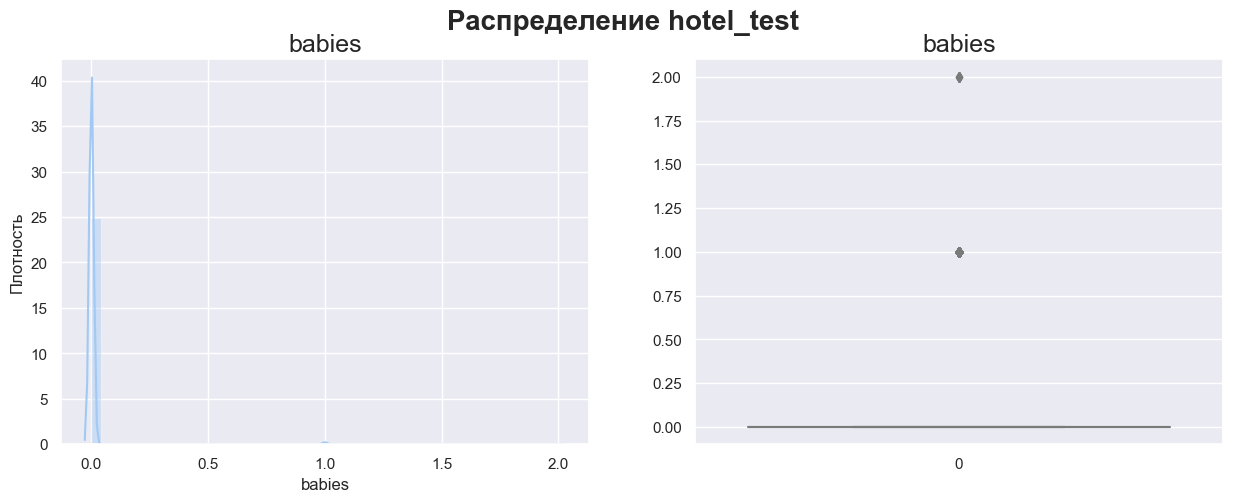

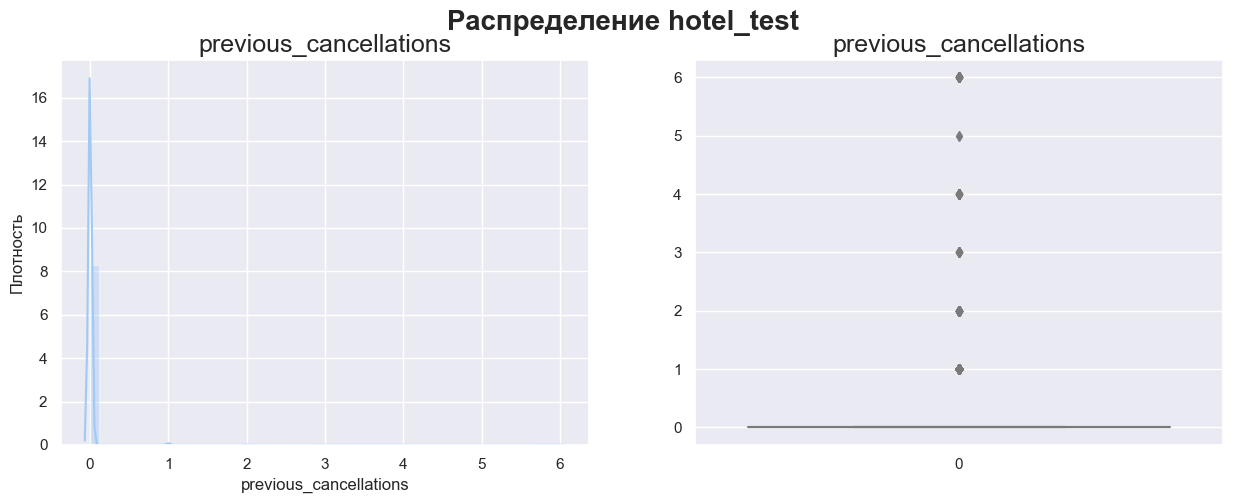

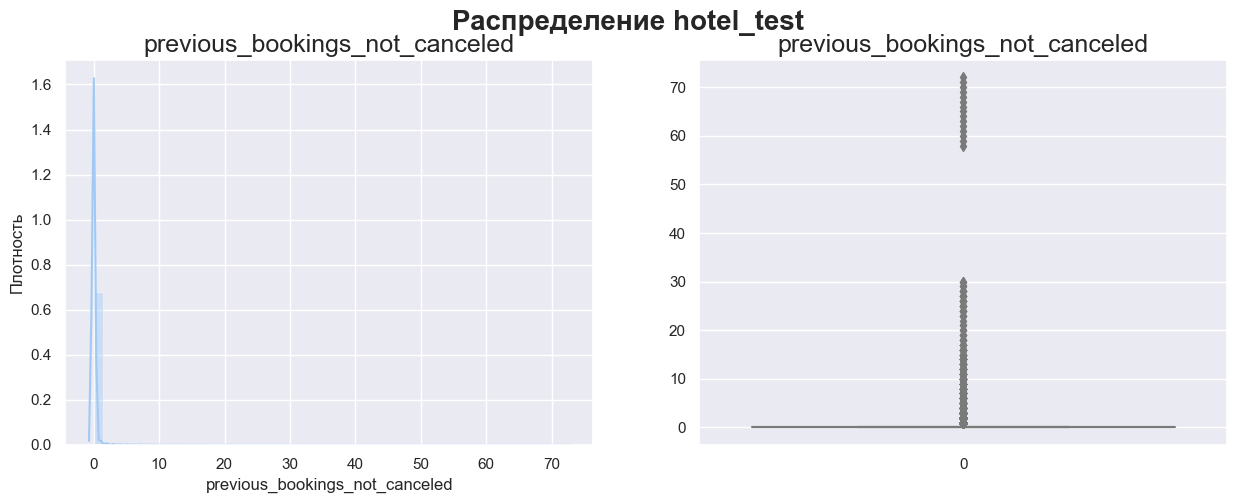

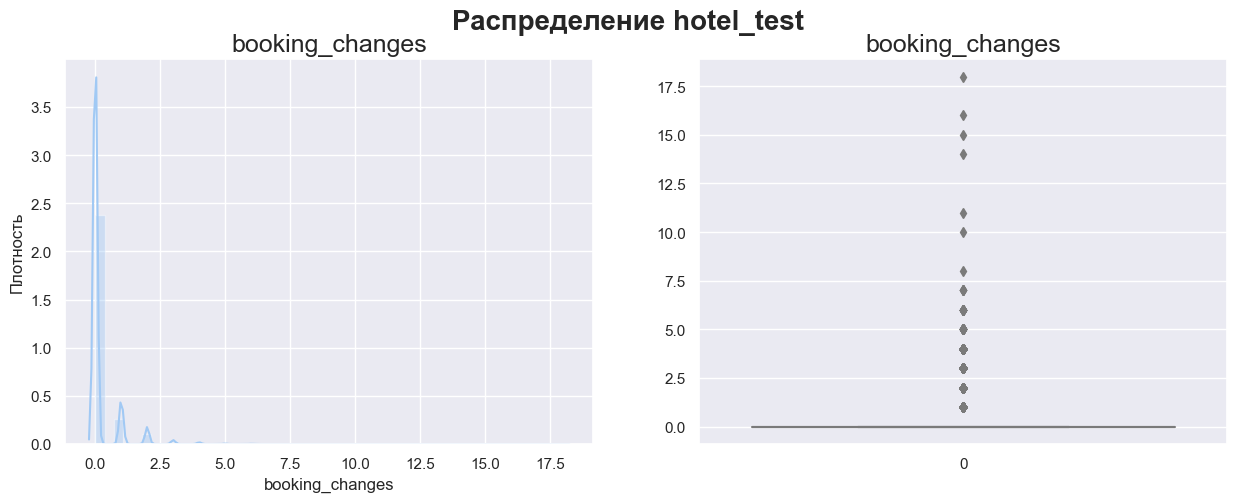

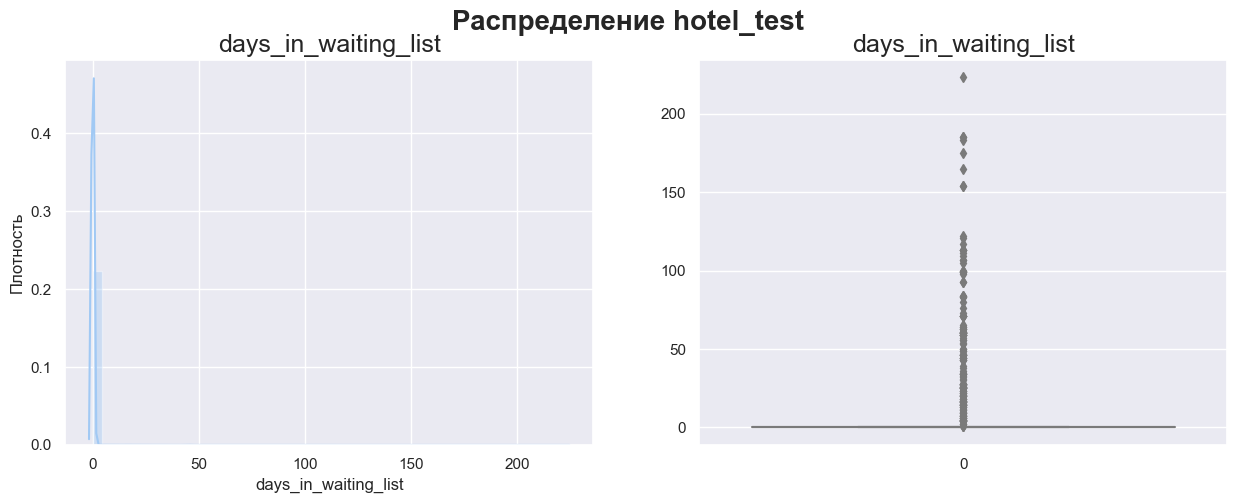

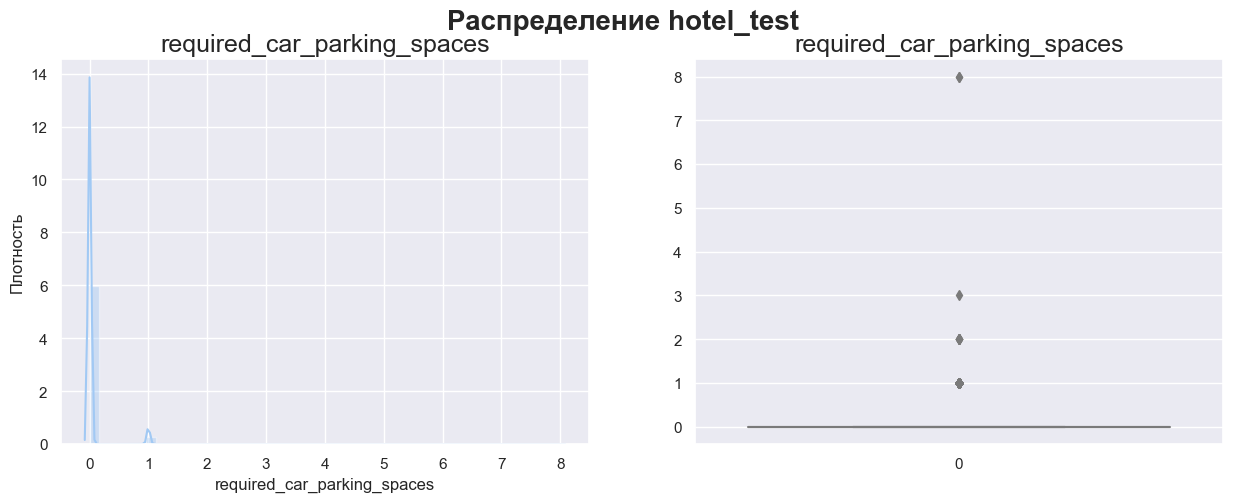

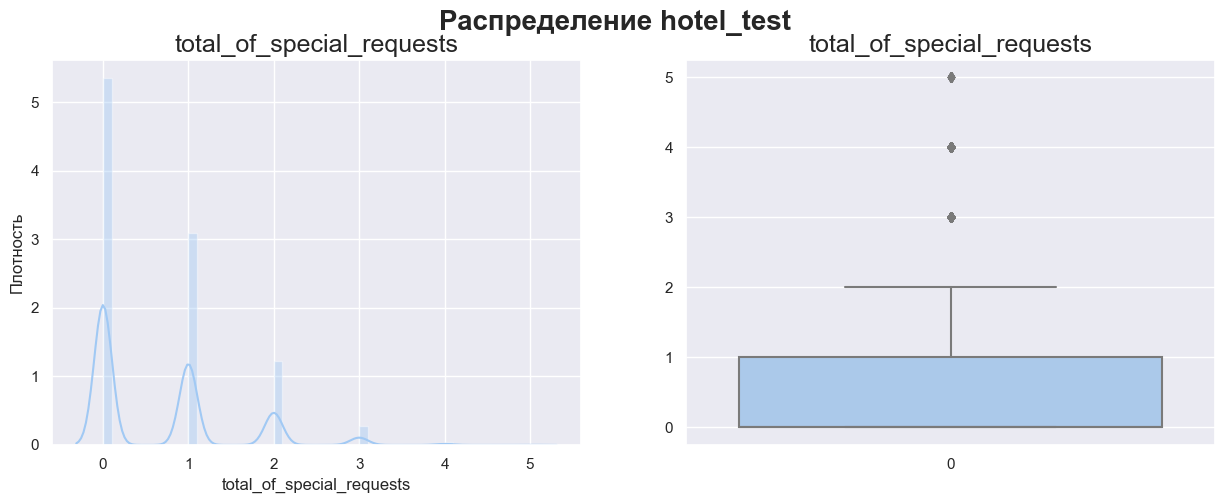

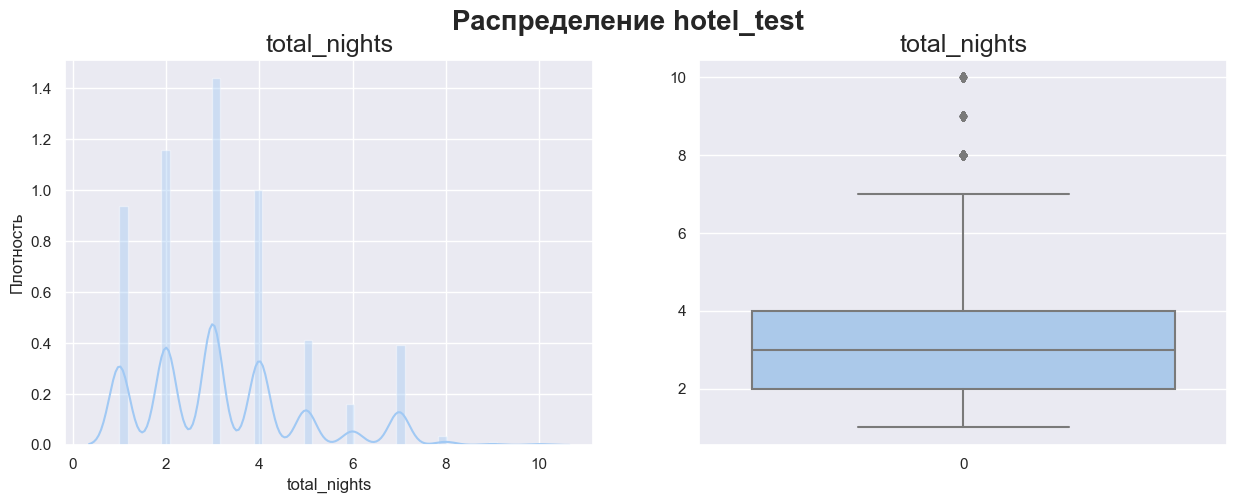

In [24]:
distribution(data_test, 'hotel_test')

Столбец с непрерывными значениями `lead_time` имеет логнормальное распределение и выбросы. Возможно, их стоит удалить. Также стоит скорректировать столбец `total_nights`. В других столбцах также есть искажения, которые являются нормой. Их мы трогать не будем.

Рассмотрим отмены номеров разных классов.

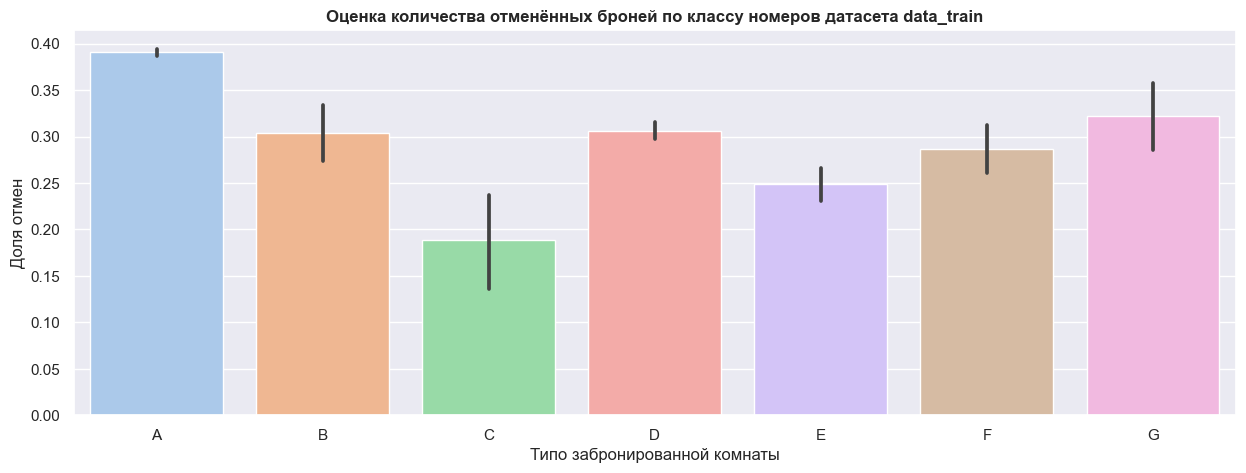

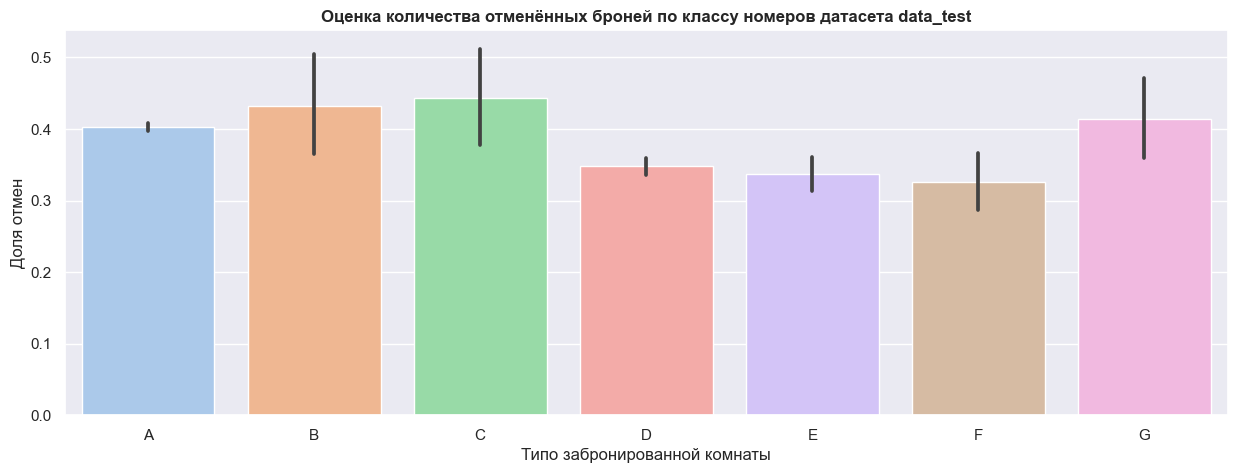

In [25]:
count = 0
for data in [data_train, data_test]:
    sns.barplot(data=data, x='reserved_room_type', y='is_canceled', order=['A','B','C','D','E','F','G'])
    plt.title(f'Оценка количества отменённых броней по классу номеров датасета {titles[count]}', fontweight='bold')
    plt.xlabel('Типо забронированной комнаты')
    plt.ylabel('Доля отмен')
    count += 1
    plt.show()

Как видим, в 2017 году (тренировочный датасет) было много отмен по классу **В, D, F и G**. На тестовой выборке много отмен по **B, C, G**. Признак **А** у нас стабильно в топе по отменам. Посмотрим на такой признак, как `required_car_parking_spaces`, там замечена высокая корреляция с сохранением бронирования номера.

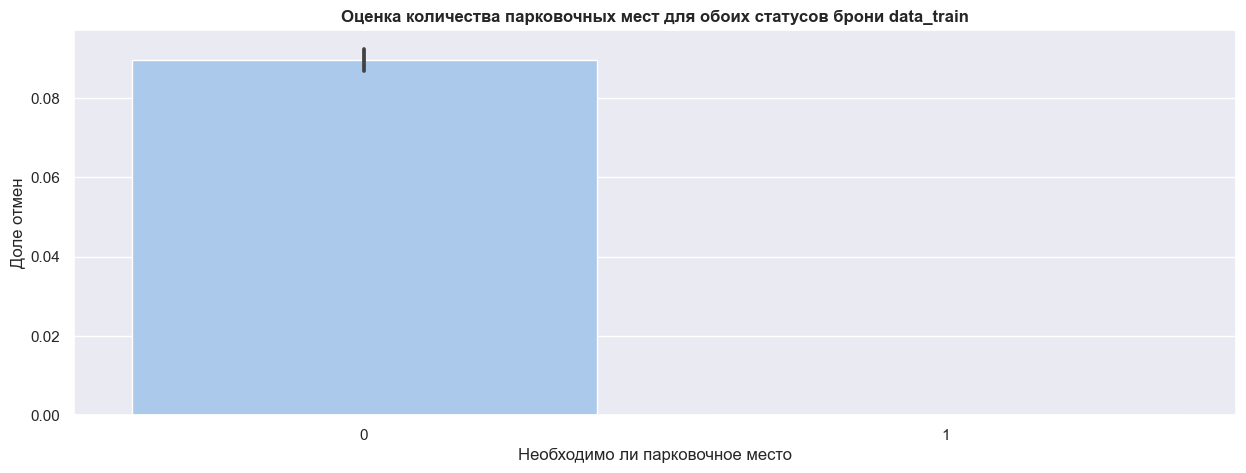

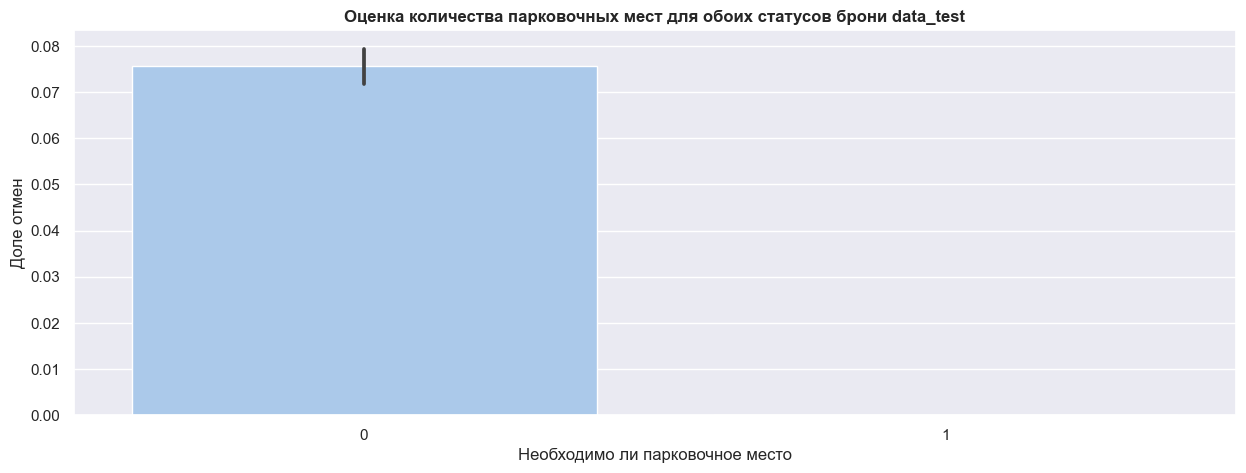

In [26]:
count = 0
for data in [data_train, data_test]:
    sns.barplot(x=data['is_canceled'], y=data['required_car_parking_spaces'])
    plt.title(f'Оценка количества парковочных мест для обоих статусов брони {titles[count]}', fontweight='bold')
    plt.xlabel('Необходимо ли парковочное место')
    plt.ylabel('Доле отмен')
    count += 1
    plt.show()

Те, кто бронирует парковочные места под авто, почти не отменяют бронирование комнат.

**Основные выводы:**
- Отменяется 37-39% брони.
- Мы наблюдаем дисбаланс целевого признака, который нужно в дальнейшем уравнять, хотя он не является критичным
- Параметр `previous_cancellations` в тренировочной выборке имеет прямую зависимость с отменой бронирования, однако в тестовой выборке - обратную зависимость. Возможно, за 2017 год у нас имеются неполные данные по этой графе.
- Пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности. Оживление может наблюдаться к Новому Году.
- Столбец с непрерывными значениями `lead_time` имеет логнормальное распределение и выбросы. Имеет средний показатель 97,5. Этот признак больше всего коррелирует с целевым.
- Те, кто бронирует парковочные места под авто, почти не отменяют бронирование комнат.
- Класс номеров A (особенно), В, С и G традиционно находится в топе по отмене броней, тогда как E и F подвержены отмене меньше всего.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

Для подсчёта прибыли создадим отдельный DataFrame с нужными признаками.

In [27]:
profit_df = pd.concat([data_train[['is_canceled', 'arrival_date_year', 'arrival_date_month', 'reserved_room_type', 'total_nights']], 
                       data_test[['is_canceled', 'arrival_date_year', 'arrival_date_month', 'reserved_room_type', 'total_nights']]]).reset_index(drop=True)

Создадим вспомогательный DataFrame со списком цен, с помощью LeftJoin добавим его к исходному DataFrame с признаками.

In [28]:
pricelist = pd.DataFrame({'reserved_room_type':[i for i in sorted(profit_df.reserved_room_type.unique())],
                          'price_per_night':[1000, 800, 600, 550, 500, 450, 350],
                          'service_price':[400, 350, 350, 150, 150, 150, 150]})
profit_df = profit_df.merge(pricelist, on='reserved_room_type', how='left')

Так как отель повышает цену на 10% весной и осенью и на 20% летом, добавим коэффициенты.

In [29]:
coeffs = pd.DataFrame({'arrival_date_month':['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                       'coefficients':[1.0, 1.0, 1.1, 1.1, 1.1, 1.2, 1.2, 1.2, 1.1, 1.1, 1.1, 1.0]})
profit_df = profit_df.merge(coeffs, on='arrival_date_month', how='left')

In [30]:
profit_df

,is_canceled,arrival_date_year,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,coefficients
0,0,2015,July,A,1,1000,400,1.2
1,0,2015,July,A,2,1000,400,1.2
2,0,2015,July,C,2,600,350,1.2
3,0,2015,July,C,2,600,350,1.2
4,1,2015,July,A,3,1000,400,1.2
...,...,...,...,...,...,...,...,...
97614,0,2017,August,A,6,1000,400,1.2
97615,0,2017,August,A,7,1000,400,1.2
97616,0,2017,August,A,7,1000,400,1.2
97617,0,2017,August,D,7,550,150,1.2


Создадим функцию для рассчёта прибыли.

In [31]:
def profit(data):
    #if data['is_canceled'] == 1:
    #    return (data['price_per_night'] * data['coefficients'] + data['service_price']) * (-1)
    #else:
    #    return data['price_per_night'] * data['total_nights'] * data['coefficients'] - (data['service_price'] * (1 + data['total_nights'] // 2))
    return (((data['price_per_night'] * data['coefficients'] + data['service_price']) * (-1)) if data['is_canceled'] == 1 
           else (data['price_per_night'] * data['total_nights'] * data['coefficients'] - (data['service_price'] * (1 + data['total_nights'] // 2))))

In [32]:
profit_df['total_profit'] = profit_df.apply(profit, axis=1)

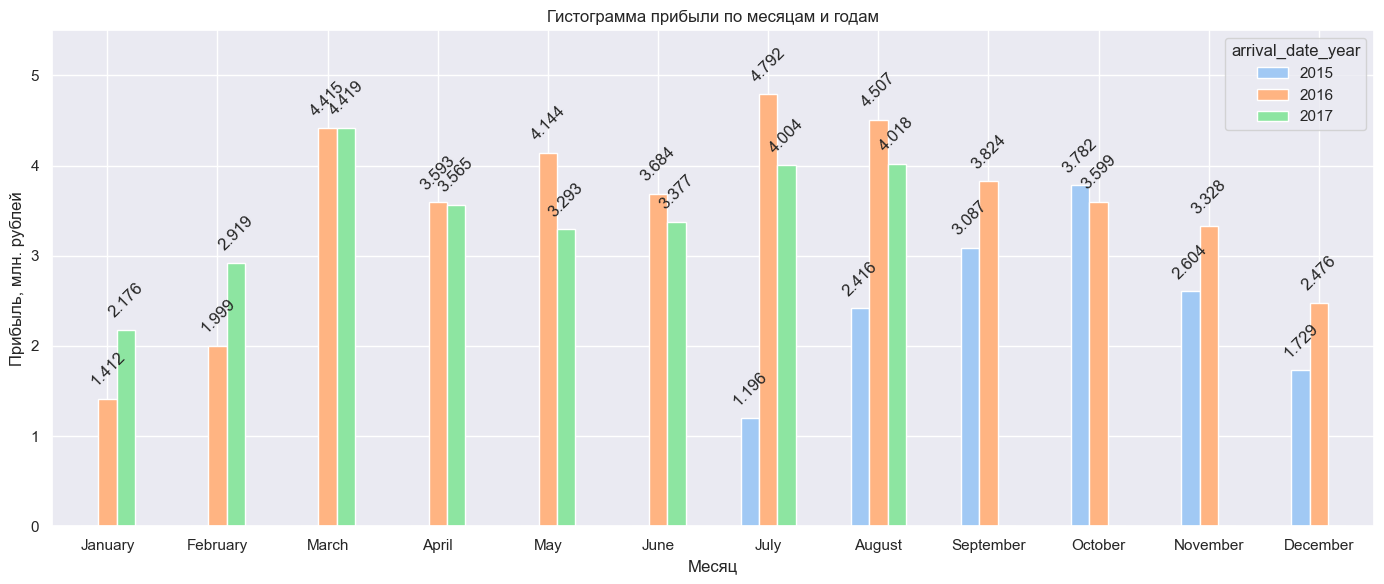

In [33]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
profit_for_gist = (profit_df.groupby(by=['arrival_date_month', 'arrival_date_year'])['total_profit'].sum() / 1000000).unstack().reindex(month_order)
ax = profit_for_gist.plot(kind='bar', stacked=False, figsize=(14, 6), ylim=(0, 5.5))

for i in ax.patches:
    if not pd.isna(i.get_height()) and i.get_height() != 0:
        ax.annotate(f'{i.get_height():.3f}', (i.get_x() + i.get_width() / 2., i.get_height()),
                    ha='center', va='baseline', rotation=45, xytext=(0, 9), textcoords='offset points')
    #value = profit_for_gist.stack()[i]
    #if pd.notnull(value):
    #    plt.text(i, value, str(round(value, 3)), ha='center', va='bottom', rotation=45)

plt.xlabel('Месяц')
plt.ylabel('Прибыль, млн. рублей')
plt.title('Гистограмма прибыли по месяцам и годам')
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')

plt.subplots_adjust(top=5, bottom=0.1, left=0.1, right=5)

plt.tight_layout()
plt.show()

Теперь подсчитаем общую прибыль с июля 2015 по август 2017.

In [34]:
print(f'Прибыль сети отелей зе период с июля 2015 по август 2017: {round(profit_for_gist.sum().sum(), 3)} млн. рублей.')

Прибыль сети отелей зе период с июля 2015 по август 2017: 84.359 млн. рублей.


Итого общая прибыль составила 84.359 млн. рублей. Теперь приступим к разработке ML модели, которая поможет нам окупить затраты на разработку модели и её внедрение, а так же принести прибыль. Для этого подготовим данные.

#### Подготовка данных для ML-модели

Создадим копию наших датасетов, чтобы не менять наши данные в дальнейшем, из копий удалим выбросы, разделим на фичи и таргет, затем преобразуем.

**Удаление выбросов**

Удалим выбросы из столбцов `lead_time` и `total_night`, чтобы корректно обучить наши модели.

In [35]:
copy_data_train = data_train.copy()
copy_data_test = data_test.copy()

In [36]:
def remove(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    upper = data.loc[data[col] >= (q3 + 1.5 * iqr)].index
    lower = data.loc[data[col] <= (q1 - 1.5 * iqr)].index
    data.drop(upper, inplace=True)
    data.drop(lower, inplace=True)

In [37]:
iter_rows = 0
while iter_rows != copy_data_train.shape[0]:
    iter_rows = copy_data_train.shape[0]
    remove(copy_data_train, 'total_nights')
    remove(copy_data_train, 'lead_time')
    remove(copy_data_test, 'total_nights')
    remove(copy_data_test, 'lead_time')
    

In [38]:
copy_data_train.shape[0], copy_data_test.shape[0]

(53311, 29525)

**Категоризация отдельных столбцов**

Удалим столбцы `arrival_date_year`, `arrival_date_month`, `arrival_date_day_of_month` и `total_nights`, так как эту информацию можно получить из двугих столбцов.

In [39]:
copy_data_train.drop(columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'total_nights'], inplace=True)
copy_data_test.drop(columns=['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'total_nights'], inplace=True)

**Разделение на признаки**

In [40]:
features_train, target_train = copy_data_train.drop(columns='is_canceled', axis=1), copy_data_train['is_canceled']
features_test, target_test = copy_data_test.drop(columns='is_canceled', axis=1), copy_data_test['is_canceled']

**Масштабирование и кодирование**

In [41]:
numeric = [*features_train.select_dtypes(exclude=['object']).columns]
numeric.remove('is_repeated_guest')
scaler = StandardScaler()
scaler.fit(pd.concat([features_train[numeric], features_test[numeric]]))
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [42]:
binary = ce.BinaryEncoder()
binary.fit(pd.concat([features_train, features_test]))
features_train = binary.transform(features_train)
features_test = binary.transform(features_test)

In [43]:
features_train.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal_0,meal_1,meal_2,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_0,distribution_channel_1,distribution_channel_2,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,booking_changes,days_in_waiting_list,customer_type_0,customer_type_1,customer_type_2,required_car_parking_spaces,total_of_special_requests
0,-0.954865,0.06174,-0.936892,-0.890104,-1.660274,-0.238141,-0.069899,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,-0.091382,-0.090522,0,0,1,-0.333144,-0.152736,0,0,1,-0.243422,-0.742237
1,-0.856379,0.06174,-0.936892,-0.019249,0.337206,-0.238141,-0.069899,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,-0.091382,-0.090522,0,0,1,-0.333144,-0.152736,0,0,1,-0.243422,0.520371
2,-1.053351,0.06174,-0.936892,-0.019249,0.337206,-0.238141,-0.069899,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,-0.091382,-0.090522,0,1,0,-0.333144,-0.152736,0,0,1,-0.243422,-0.742237
3,-0.926726,0.06174,-0.936892,-0.019249,0.337206,-0.238141,-0.069899,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.091382,-0.090522,0,1,0,-0.333144,-0.152736,0,0,1,-0.243422,0.520371
4,0.142551,0.06174,-0.936892,0.851605,0.337206,-0.238141,-0.069899,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,-0.091382,-0.090522,0,0,1,-0.333144,-0.152736,0,0,1,-0.243422,0.520371


In [44]:
features_test.head()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal_0,meal_1,meal_2,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_0,distribution_channel_1,distribution_channel_2,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,booking_changes,days_in_waiting_list,customer_type_0,customer_type_1,customer_type_2,required_car_parking_spaces,total_of_special_requests
0,-0.012213,-1.789382,0.313666,-1.760958,0.337206,-0.238141,-0.069899,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,-0.091382,-0.090522,0,0,1,-0.333144,-0.152736,0,0,1,-0.243422,-0.742237
1,-0.181046,-1.789382,1.564225,-0.019249,0.337206,-0.238141,-0.069899,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,-0.091382,-0.090522,0,0,1,-0.333144,-0.152736,0,0,1,-0.243422,0.520371
2,-0.181046,-1.789382,1.564225,-0.019249,0.337206,-0.238141,-0.069899,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,-0.091382,-0.090522,0,0,1,-0.333144,-0.152736,0,0,1,-0.243422,0.520371
3,-0.054421,-1.789382,1.564225,-0.019249,-1.660274,-0.238141,-0.069899,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,-0.091382,-0.090522,0,0,1,-0.333144,-0.152736,0,0,1,-0.243422,0.520371
6,0.958578,-1.789382,0.313666,-0.890104,0.337206,-0.238141,-0.069899,0,0,1,0,0,0,1,1,0,1,1,0,0,1,0,-0.091382,-0.090522,0,0,1,1.311061,-0.152736,0,0,1,-0.243422,0.520371


**Увеличение обучающей выборки**

Данные готовы, признаки разделены, преобразованы. Сделали масштабирование. Для борьбы с дисбалансом классов в будущем будем использовать `class_weight='balanced'`.

### Шаг 4. Разработка модели ML

Для оценки качества модели будем использовать метрику **recall**. Для нас важно минимизировать количество ложноотрицательных ответов модели: клиентов, которые отменят бронирование, но модель решила, что они заселятся, поскольку в этом случае отель несёт больше всего убытков.

Напишем функции для обучения моделей и вывода оценок.

In [45]:
def fitting(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', n_jobs=-1)
    grid_search.fit(features_train, target_train)

    print(f'Наивысшее значение \'recall\' примерно равно {round(grid_search.best_score_, 5)} и достигается при следующих гиепрпараметрах {grid_search.best_params_}')
    return grid_search.best_estimator_

In [46]:
def scoring(model):
    scores = cross_val_score(model, features_test, target_test, cv=5, scoring='recall', n_jobs=-1)

    print("Оценки на новых данных: ", scores)
    print("Средняя оценка на новых данных: ", round(scores.mean(), 5))

#### DecisionTreeClassifierb

Зададим параметры для `GridSearchCV`.

In [47]:
param_grid = {
    'max_depth':[4, 6, 10, 18, 25]
}

Применим `GridSearchCV`.

In [48]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=state)

model = fitting(model, param_grid)

Наивысшее значение 'recall' примерно равно 0.64402 и достигается при следующих гиепрпараметрах {'max_depth': 4}


Проверим полученную модель на тестовой выборке.

In [49]:
scoring(model)

Оценки на новых данных:  [0.53519895 0.55618714 0.79580236 0.75338872 0.69510061]
Средняя оценка на новых данных:  0.66714


#### RandomForestClassifier

Зададим параметры для `GridSearchCV`.

In [50]:
param_grid = {
    'n_estimators':[5, 10, 18, 30, 40],
    'max_depth':[4, 6, 10, 18, 25]
}

Применим `GridSearchCV`.

In [51]:
model = RandomForestClassifier(class_weight='balanced', random_state=state)

model = fitting(model, param_grid)

Наивысшее значение 'recall' примерно равно 0.65066 и достигается при следующих гиепрпараметрах {'max_depth': 6, 'n_estimators': 5}


Промерим полученную модель на тестовой выборке.

In [52]:
scoring(model)

Оценки на новых данных:  [0.57498907 0.54962833 0.69261041 0.90599038 0.68635171]
Средняя оценка на новых данных:  0.68191


#### LogisticRegression

Зададим параметры для `GridSearchCV`.

In [53]:
param_grid = {
    'solver':['liblinear', 'lbfgs']
}

Применим `GridSearchCV`.

In [54]:
model = LogisticRegression(class_weight='balanced', random_state=state)

model = fitting(model, param_grid)

Наивысшее значение 'recall' примерно равно 0.68128 и достигается при следующих гиепрпараметрах {'solver': 'liblinear'}


Промерим полученную модель на тестовой выборке.

In [55]:
scoring(model)

Оценки на новых данных:  [0.62745955 0.6545693  0.81591605 0.81460429 0.72615923]
Средняя оценка на новых данных:  0.72774


Опираясь на значения метрики `recall`, среди рассмотренных трёх моделей наилучшей себя показала модель **Логистической Регрессии** с примерными значениями равными 0.68 и 0.73 для обучающей и тестовой выборках соответственно.

#### Подсчёт прибыль, которую принесёт модель за тестовый период

В нашем случае тестовый период - это 8 месяцев. Нам известны предсказания и правильные ответы. Соответственно, мы можем определить, насколько модель помогает избежать убытков в случае отмены брони. Если модель не предсказала отмену брони, то компания несёт убытки в остальных случаях - оказывается в плюсе.

Построим вспомогательный DataFrame.

In [56]:
profit_after_model = data_test[['is_canceled', 'lead_time', 'arrival_date_month', 'reserved_room_type', 'total_nights']]

iter_rows = 0
while iter_rows != profit_after_model.shape[0]:
    iter_rows = profit_after_model.shape[0]
    remove(profit_after_model, 'total_nights')
    remove(profit_after_model, 'lead_time')

profit_after_model.drop('lead_time', axis = 1, inplace=True)

profit_after_model = profit_after_model.merge(pricelist, on='reserved_room_type', how='left')
profit_after_model = profit_after_model.merge(coeffs, on='arrival_date_month', how='left')
profit_after_model['total_profit'] = profit_after_model.apply(profit, axis=1)
profit_after_model['pred_is_canceled'] = pd.Series(model.predict(features_test)).reset_index(drop=True)

In [57]:
profit_after_model.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,coefficients,total_profit,pred_is_canceled
0,1,January,A,1,1000,400,1.0,-1400.0,1
1,1,January,A,4,1000,400,1.0,-1400.0,0
2,1,January,A,4,1000,400,1.0,-1400.0,0
3,1,January,A,4,1000,400,1.0,-1400.0,1
4,1,January,A,2,1000,400,1.0,-1400.0,0


Вычислим прибыль с каждого бронирования и добавим к текущему DataFrame.

In [58]:
def total_profit_after_modeling(data):
    if data['pred_is_canceled'] == 0:
        return data['total_profit']
    else:
        if data['is_canceled'] == 1:
            return (data['price_per_night'] + data['service_price']) * 0.8
        else:
            return data['total_profit']

In [59]:
profit_after_model['total_profit_with_model'] = profit_after_model.apply(total_profit_after_modeling, axis=1)

In [60]:
profit_after_model.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,coefficients,total_profit,pred_is_canceled,total_profit_with_model
0,1,January,A,1,1000,400,1.0,-1400.0,1,1120.0
1,1,January,A,4,1000,400,1.0,-1400.0,0,-1400.0
2,1,January,A,4,1000,400,1.0,-1400.0,0,-1400.0
3,1,January,A,4,1000,400,1.0,-1400.0,1,1120.0
4,1,January,A,2,1000,400,1.0,-1400.0,0,-1400.0


Рассчитаем прибыль.

In [61]:
print('Прибыль после внедрения модели за 8-месячный период составляет:', round(profit_after_model['total_profit_with_model'].sum() / 1000000, 3), 'млн. рублей.')
print('Прибыль с бронирований, которые модель предсказала отменёнными:', round(profit_after_model[profit_after_model['pred_is_canceled'] == 1]['total_profit_with_model'].sum() / 1000000, 3), 'млн. рублей')
print('Прибыль с депозитов:', round(profit_after_model[(profit_after_model['pred_is_canceled'] == 1) & (profit_after_model['is_canceled'] == 1)]['total_profit_with_model'].sum() / 1000000, 3), 'млн. рублей')

Прибыль после внедрения модели за 8-месячный период составляет: 40.156 млн. рублей.
Прибыль с бронирований, которые модель предсказала отменёнными: 18.878 млн. рублей
Прибыль с депозитов: 8.386 млн. рублей


Следовательно, модель **Логистической регрессии** нам полностью подходит. Благодаря предсказаниям модель, удалось получить прибыль с отменённых бронирований примерно равную 8.4 млн. рублей, что окупает затраты на разработку модели в 400 тыс. рублей. Стоит отметить, что метрика `recall` на приемлемом уровне, с такой моделью можно работать дальше.

### Шаг 5. Портрет «ненадёжного» клиента

Построим график важности признаков

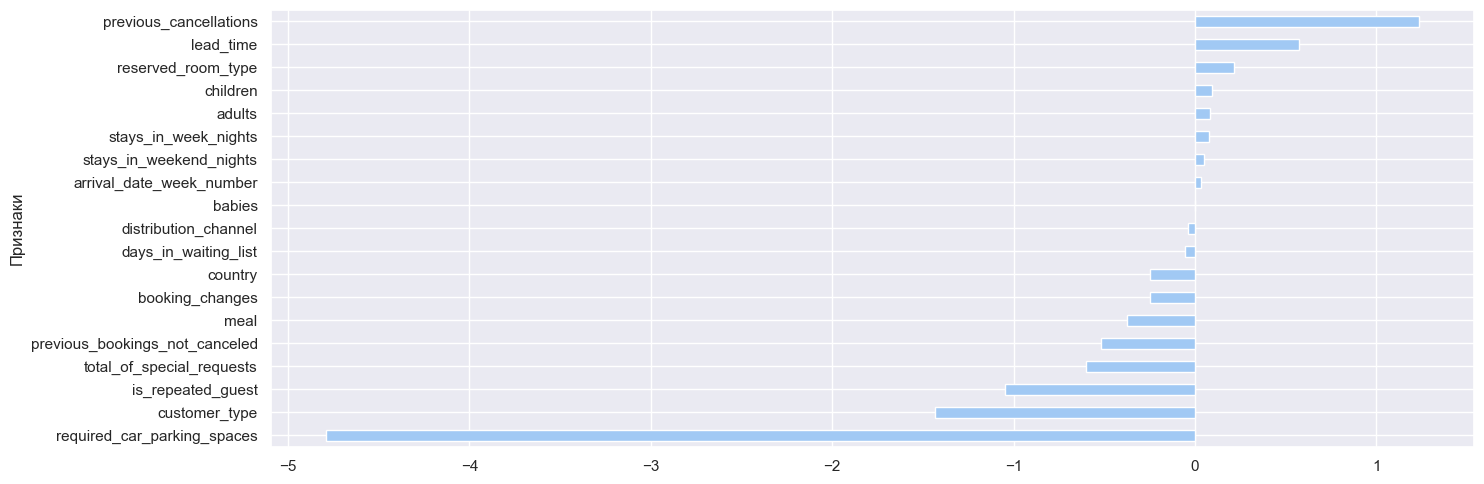

In [62]:
importance = pd.Series(model.coef_[0], features_train.columns)
importance['country'] = importance[['country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7']].mean()
importance['customer_type'] = importance[['customer_type_0', 'customer_type_1', 'customer_type_2']].mean()
importance['distribution_channel'] = importance[['distribution_channel_0', 'distribution_channel_1', 'distribution_channel_2']].mean()
importance['meal'] = importance[['meal_0', 'meal_1', 'meal_2']].mean()
importance['reserved_room_type'] = importance[['reserved_room_type_0', 'reserved_room_type_1', 'reserved_room_type_2']].mean()
importance.drop(['country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
                 'customer_type_0', 'customer_type_1', 'customer_type_2',
                 'distribution_channel_0', 'distribution_channel_1', 'distribution_channel_2',
                 'meal_0', 'meal_1', 'meal_2',
                 'reserved_room_type_0', 'reserved_room_type_1', 'reserved_room_type_2'], inplace=True)
importance.sort_values(inplace=True)
importance.plot(kind='barh')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

Отсюда можно сделать следующие выводы:
- чем больше раз клиент отменял бронирования, тем выше вероятность повторной отмены (`previous_cancellations`);
- чем больше времени между бронированием и выездом, тем выше вероятность отказа, поскольку есть время передумать (`lead_time`);
- если есть требования к парковочным местам, то вероятность отказа от бронирования ниже (`required_car_parking_spaces`); 
- если гость до этого оставался в отеле, то ниже вероятность отмены в дальнейшем (`is_repeated_guest`);
- чем больше специальных отметок, тем ниже вероятность отказа, гости, которые оставляют отметки или пожелания, вероятно, заинтересованы в том, чтобы снять номер (`total_of_special_requests`).

---

Рассмотрим детально категориальные признаки и их зависимости.

Добавим к рассматриваемому датасету столбец с предсказаниями, чтобы делать сравнительные таблицы.

In [63]:
copy_data_test['pred_is_canceled'] = model.predict(features_test)
copy_data_test.head()

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,pred_is_canceled
0,1,74,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,1,62,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,0
2,1,62,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,0
3,1,71,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,1
6,1,143,1,1,1,2,0,0,BB,BRA,Direct,0,0,0,A,1,0,Transient,0,1,0


Создадим функцию для сравнение категариальных признаков относительно фактического и предсказанного целевых признаков

In [64]:
def cat_comparison(col):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle(f'Сравнение зависимости отмены бронирования от категорий {col}', fontweight='bold')
    sns.barplot(data=copy_data_test, x=col, y='is_canceled', ax=ax[0])
    ax[0].set_title('Фактические отмены')
    ax[0].set_xlabel('Категории')
    ax[0].set_ylabel('Зависимость целевого признака')
    sns.barplot(data=copy_data_test, x=col, y='pred_is_canceled', ax=ax[1])
    ax[1].set_title('Предсказанные отмены')
    ax[1].set_xlabel('Категории')
    ax[1].set_ylabel('Зависимость целевого признака')
    plt.show()
    val_counts = copy_data_test.value_counts(col).to_frame()
    val_counts.columns = ['percent']
    val_counts['percent'] = (val_counts['percent'] / val_counts['percent'].sum()).apply(lambda x: '{0:.2%}'.format(x))
    display(val_counts)

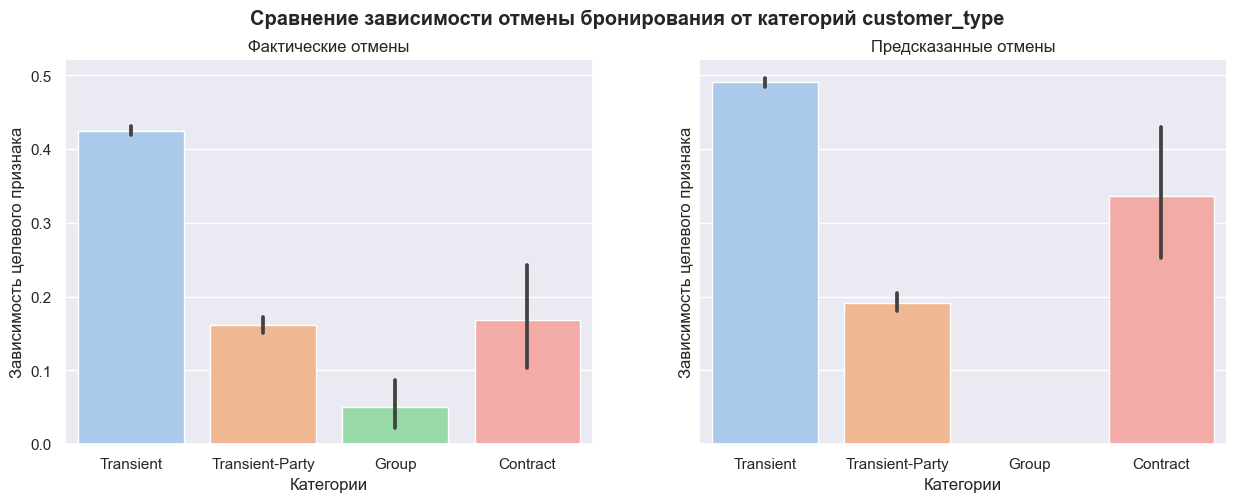

,percent
customer_type,
Transient,85.83%
Transient-Party,13.34%
Group,0.47%
Contract,0.36%


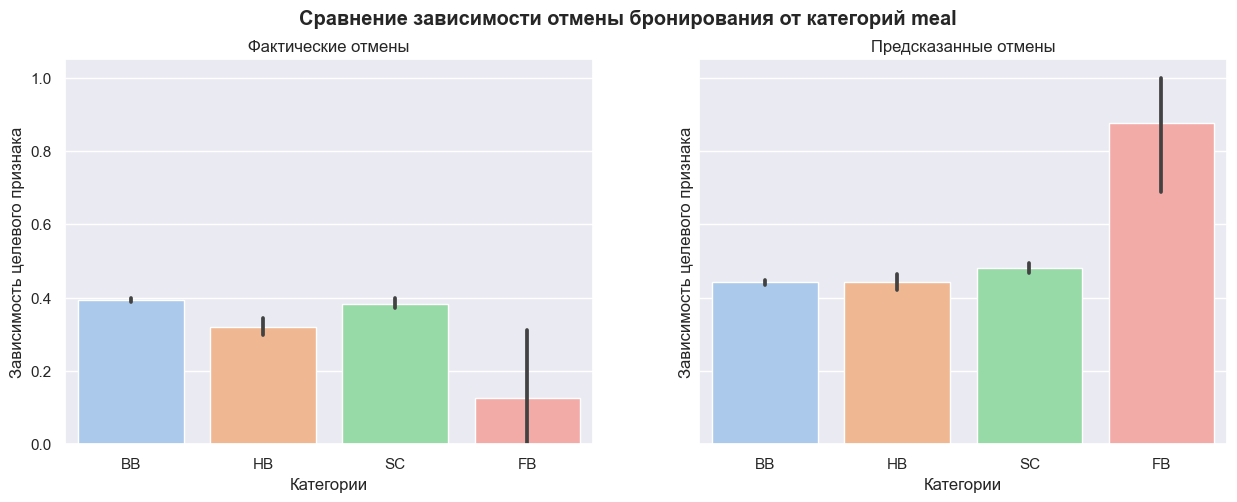

,percent
meal,
BB,76.99%
SC,16.98%
HB,5.98%
FB,0.05%


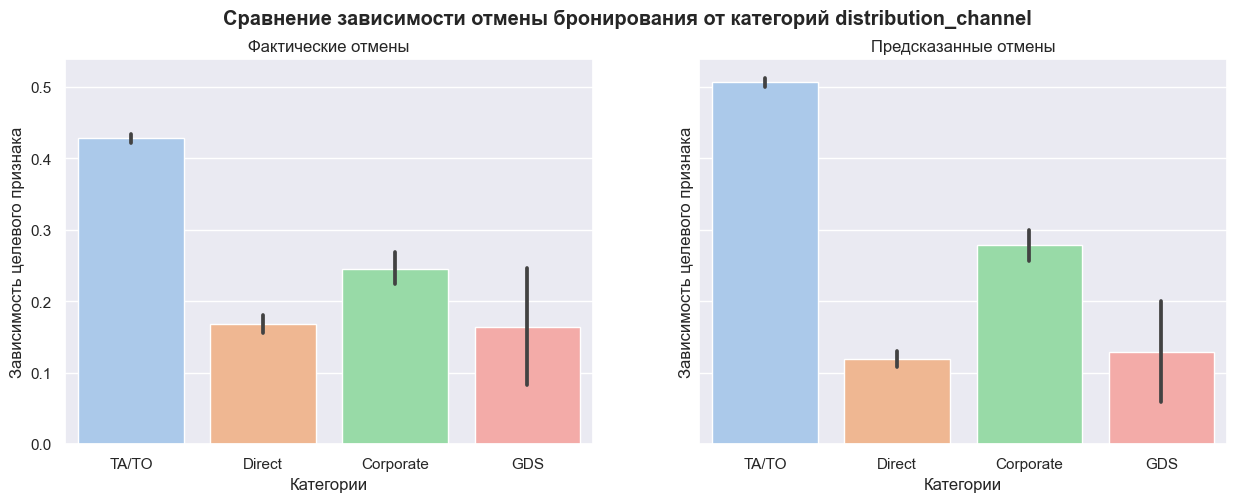

,percent
distribution_channel,
TA/TO,82.79%
Direct,11.64%
Corporate,5.28%
GDS,0.29%


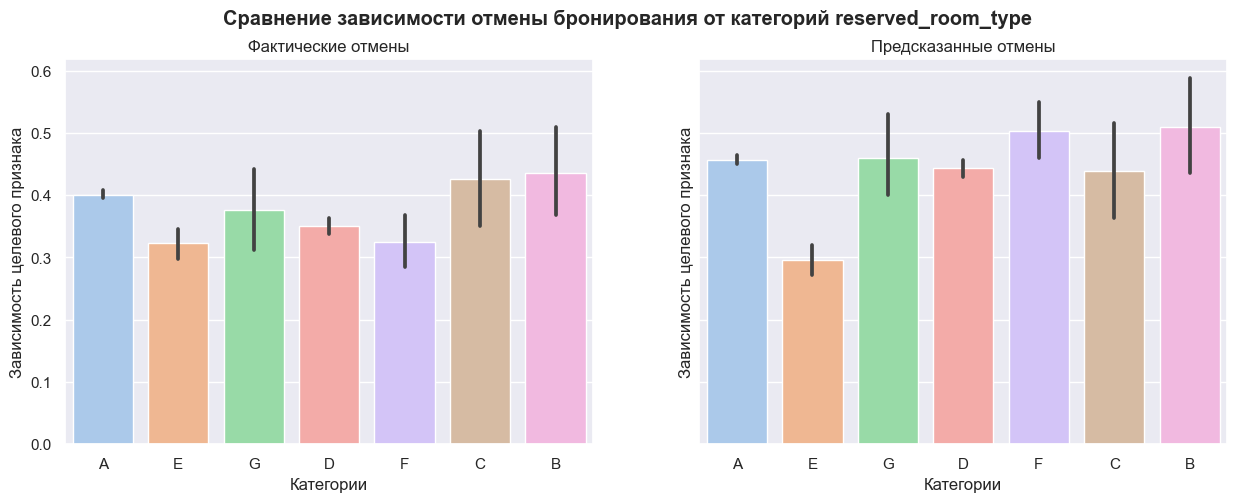

,percent
reserved_room_type,
A,73.72%
D,18.22%
E,4.71%
F,1.53%
G,0.73%
B,0.55%
C,0.53%


In [65]:
cols = ['customer_type', 'meal', 'distribution_channel', 'reserved_room_type']
for col in cols:
    cat_comparison(col)

**Выводы:**
- по типу заказчика больше всех отменяет категория Transient, но модель сместила выбор в пользу самой низкой - Group, что не так важно, учитывая общую долю этой категории менее 1%;
- по категориям meal у нас нет особых скачков, все категории где-то на уровне 0,4. Модель отдала предпочтение категории FB, что также незначительно, тк она занимает менее 1% и вряд ли способна навредить метрикам предсказаний;
- по категориям дистрибуции заказа выделяются TA/TO и Corporate. Что касается модели, то наблюдается та же картина, что и в предыдущих категориях - заметен скачок на категории GDS, которая занимает менее 1%;
- по reserved_room_type мы уже отмечали, что отменяют в основном категории А, В, С, G. Модель в общих чертах воспроизвела эти зависимости.

___

Рассмотрим признак `country`

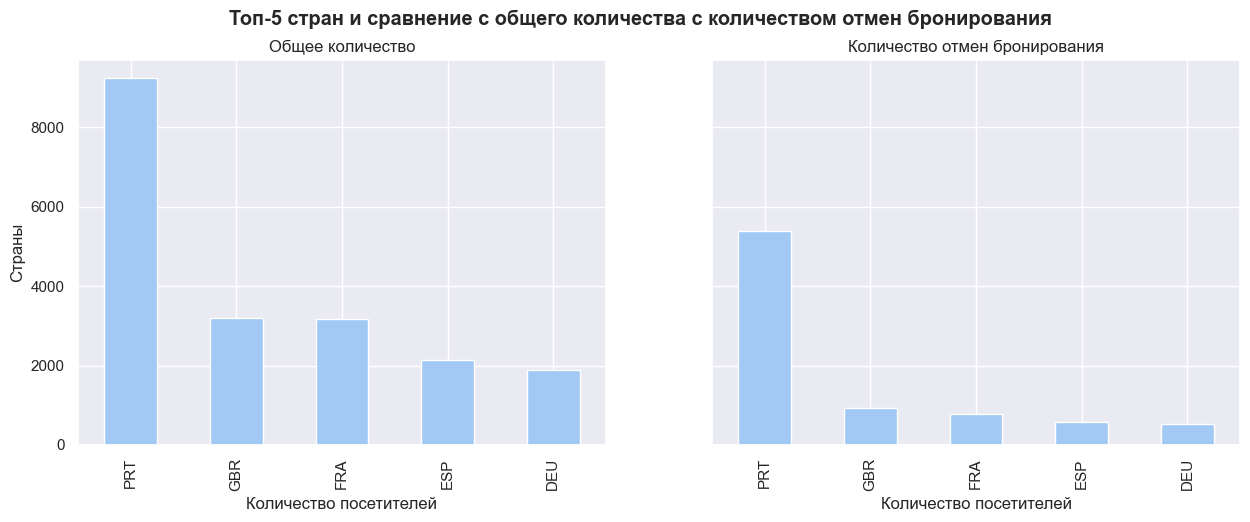

In [66]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Топ-5 стран и сравнение с общего количества с количеством отмен бронирования', fontweight="bold")
copy_data_test.value_counts('country').nlargest(5).plot(kind='bar', ax=ax[0])
ax[0].set_title('Общее количество')
ax[0].set_xlabel('Количество посетителей')
ax[0].set_ylabel('Страны')
copy_data_test.query('is_canceled == 1')['country'].value_counts().nlargest(5).plot(kind='bar', ax=ax[1])
ax[1].set_title('Количество отмен бронирования')
ax[1].set_xlabel('Количество посетителей')
plt.show()

Как видим, большинство посетителей приезжает из Португалии. Около половины из них отменяет бронирование. И это идет вразрез с практикой уроженцев других стран.

___

**Общие выводы о "ненадёжных клиентах":**
- на ненадежность очень сильно влияет время ожидания между датой бронирования и заездом в отель. Конечно же, это связано с тем, что чем больше времени есть на раздумья, тем выше шанс отказа;
- в то же время есть признаки, которые снижают вероятность отмены: наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке и тд. выявляют серьезные намерения у клиента;
- забронированные группами или юрлицами места реже подвергаются отменам. Как и номера категории E, D, F;
- большую долю гостей составляют посетители из Португалии, которые, к тому же, непропорционально часто отменяют брони.

### Шаг 6. Напишите общий вывод

По окончанию исследования подведём итог:
- Проведена предобработка данных: удалили лишний столбец id, неинформативный в нашем деле, выявили дубликаты, которые решено было оставить, поскольку мы не знаем их истинную природу. В том числе исправили категориальные значения, в которых были ошибки и удалили единичные строки с нулевым количеством постояльцев.
- Исследовательском анализе выявлен дисбаланс целевого признака: отменяется 37-39 % брони. В дальнейшем при обучении модели воспользовались `class_weight='balanced'` для решения этой проблемы. Выявлено, что столбец с непрерывными значениями `lead_time` имеет логнормальное распределение и выбросы. Этот признак больше всего коррелирует с целевым. В нем удалили выбросы, как и в столбце `total_nights`. Остальные признаки мы не трогали.
- Подготовка данных для машинного обучения: разделение признаков, масштабирование и кодирование тренировочной выборки через Binary Encoder. 
- Обучение трёх моделей: дерево решений, случайный лес, логистическая регрессия. В качестве целевой метрики выбрана `recall`, так как было важно не отправить потенциальных отказников в список тех, кто точно не откажется от брони. Ведь именно в этом случае мы теряли деньги.
- Из рассмотренных моделей лучше всего себя показала модель **логистической регрессии** с самым высоким показателем `recall`, как на обучающей, так и на тестовой выборках. Такая модель принесла бы прибыль минимум до 8.4 млн. руб, опираясь на тестовую выборку. И это позволяет окупить затраты в 400 тыс. руб на создание модели. 
- Оценивая портрет *"ненадежного"* клиента получен вывод, что на ненадежность очень сильно влияет время ожидания между датой бронирования и заездом в отель. Конечно же, это связано с тем, что чем больше времени есть на раздумья, тем выше шанс отказа. В то же время наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке отрицательно влияют на отмену бронирования. Конечно же, забронированные группами или юрлицами места реже подвергаются отменам. Как и номера категории E, D, F.
- Особенно стоит обратить внимание на посетителей из Португалии. Они составляют большую долю бронирований в отеле, но и частенько (около половины общего количества) их отменяют. Возможно, стоит отдельно выделить данную категорию гостей и понаблюдать. Если доля отмен будет увеличиваться, обложить их депозитом отдельно. Впрочем, модель и так достаточно хорошо предсказывает отмены.